In [67]:
import numpy as np
import pandas as pd
import csv
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind, ttest_rel

In [4]:
"""Pareto smoothed importance sampling (PSIS)

This module implements Pareto smoothed importance sampling (PSIS) and PSIS
leave-one-out (LOO) cross-validation for Python (Numpy).

Included functions
------------------
psisloo
    Pareto smoothed importance sampling leave-one-out log predictive densities.

psislw
    Pareto smoothed importance sampling.

gpdfitnew
    Estimate the paramaters for the Generalized Pareto Distribution (GPD).

gpinv
    Inverse Generalised Pareto distribution function.

sumlogs
    Sum of vector where numbers are represented by their logarithms.

References
----------
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Practical
Bayesian model evaluation using leave-one-out cross-validation
and WAIC. Statistics and Computing, 27(5):1413–1432.
doi:10.1007/s11222-016-9696-4. https://arxiv.org/abs/1507.04544

Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Pareto
smoothed importance sampling. https://arxiv.org/abs/arXiv:1507.02646v5

"""

from __future__ import division # For Python 2 compatibility
import numpy as np

# 3-Clause BSD License
"""
Copyright 2017 Aki Vehtari, Tuomas Sivula

Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation and/or
other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. """


def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.

    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).

    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).

    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.

    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities

    loos : ndarray
        individual leave-one-out log predictive density terms

    ks : ndarray
        estimated Pareto tail indeces

    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    return loo, loos, ks


def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).

    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.

    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``

    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.

    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices

    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)

    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.

    Parameters
    ----------
    x : ndarray
        One dimensional data array

    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.

    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).

    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.

    Returns
    -------
    k, sigma : float
        estimated parameter values

    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.

    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.

    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.

    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.

    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out

In [ ]:
subject_num = 60
def read_data(n):  #read behavioral data; no action: action[i]=4
    #数据文件在的位置
    action = []
    reward = []
    reward_B = []
    comparision = [] #r-r_b; 1:>=0, 0:<0
    
    subject = [1,2,3,4,5,6,7,8,9,10,
               11,12,13,14,15,16,17,18,19,20,
               21,22,23,24,25,26,27,28,29,30,
               31,32,33,34,35,36,37,38,39,40,
               41,42,43,44,45,46,47,48,49,50,
               51,52,53,54,55,56,58,59,60,61]
    
    num = str(100+subject[n])
    file = pd.read_csv('./data/' + num + '.csv')
    name = 'sub (' +str(n) +').csv'
    action_index = 0
    for i in  range((file.shape[1])):
        if file.columns[i] == 'choose_bandit.keys':
            action_index = i
    reward_index = 0
    for i in  range((file.shape[1])):
        if file.columns[i] == 'subchoose':
            reward_index = i
    for i in range((file.shape[0])):

        if file.iloc[i,0] == 1 and file.iloc[i,action_index]!='None' :
            if file.iloc[i,action_index] == 'r':
                action.append(0)
            elif file.iloc[i,action_index] == 'f':
                action.append(1)
            elif file.iloc[i,action_index] == 'i':
                action.append(2)
            elif file.iloc[i,action_index] == 'j':
                action.append(3)
            else:
                print(file.iloc[i,action_index])
                print(i)
                raise ValueError('不能识别选项')
            reward.append(int(file.iloc[i,reward_index]))
            reward_B.append(int(file.iloc[i,reward_index+1]))
            if int(file.iloc[i,reward_index]) >= int(file.iloc[i,reward_index+1]):
                comparision.append(int(file.iloc[i,reward_index])-int(file.iloc[i,reward_index+1]))
            else:
                comparision.append(int(file.iloc[i,reward_index+1])-int(file.iloc[i,reward_index]))
        elif file.iloc[i,0] == 1 and file.iloc[i,action_index] =='None' :
            action.append(4)
            reward.append(0)
            reward_B.append(0)
            comparision.append(0)
    return action,reward,reward_B,comparision
    

In [6]:
def read_parameter_1_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta = []
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    beta = np.array(beta)
    return beta

def read_parameter_2_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta = []
    phi = []
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
    beta = np.array(beta)
    phi = np.array(phi)
    return beta,phi

def read_parameter_3_para(file_name):
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    para1 = []
    para2 = []
    para3 = []
    for i in range(subject_num):
        para1.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        para2.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        para3.append(parameter_result.iloc[i+subject_num*2,1])
    para1 = np.array(para1)
    para2 = np.array(para2)
    para3 = np.array(para3)
    return para1,para2,para3

def read_parameter_4_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta = []
    phi = []
    persev = []
    gamma = []
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma.append(parameter_result.iloc[i+subject_num*3,1])
    beta = np.array(beta)
    phi = np.array(phi)
    persev = np.array(persev)
    gamma = np.array(gamma)
    return beta,phi,persev,gamma

def read_parameter_5_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []


    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])


    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)


    return beta_a,phi_a,persev_a,gamma_a,beta_b

def read_parameter_6_para(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a = []
    phi_a = []
    persev_a = []

    beta_b = []
    phi_b = []
    persev_b = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])

    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*5,1])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)

    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)

    return beta_a,phi_a,persev_a,beta_b,phi_b,persev_b

def read_parameter_7_para(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []
    phi_b = []
    persev_b = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*6,1])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)

    return beta_a,phi_a,persev_a,gamma_a,beta_b,phi_b,persev_b

def read_parameter_8_para(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []
    phi_b = []
    persev_b = []
    gamma_b = []
    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*6,1])
    for i in range(subject_num):
        gamma_b.append(parameter_result.iloc[i+subject_num*7,1])
    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)
    gamma_b = np.array(gamma_b)
    return beta_a,phi_a,persev_a,gamma_a,beta_b,phi_b,persev_b,gamma_b

def read_parameter_9_para(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a_0 = []
    phi_a_0 = []
    persev_a_0 = []
    gamma_a_0 = []
    
    beta_a_1 = []
    phi_a_1 = []
    persev_a_1 = []
    gamma_a_1 = []
    
    beta_b = []

    for i in range(subject_num):
        beta_a_0.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a_0.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a_0.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a_0.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_a_1.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_a_1.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_a_1.append(parameter_result.iloc[i+subject_num*6,1])
    for i in range(subject_num):
        gamma_a_1.append(parameter_result.iloc[i+subject_num*7,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*8,1])

        
    beta_a_0 = np.array(beta_a_0)
    phi_a_0 = np.array(phi_a_0)
    persev_a_0 = np.array(persev_a_0)
    gamma_a_0 = np.array(gamma_a_0)
    
    beta_a_1 = np.array(beta_a_1)
    phi_a_1 = np.array(phi_a_1)
    persev_a_1 = np.array(persev_a_1)
    gamma_a_1 = np.array(gamma_a_1)
    
    beta_b = np.array(beta_b)

    return beta_a_0,phi_a_0,persev_a_0,gamma_a_0,beta_a_1,phi_a_1,persev_a_1,gamma_a_1,beta_b

def read_parameter_12_para(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a_0 = []
    phi_a_0 = []
    persev_a_0 = []
    gamma_a_0 = []
    
    beta_a_1 = []
    phi_a_1 = []
    persev_a_1 = []
    gamma_a_1 = []
    
    beta_b = []
    phi_b = []
    persev_b = []
    gamma_b = []
    for i in range(subject_num):
        beta_a_0.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a_0.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a_0.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a_0.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_a_1.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_a_1.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_a_1.append(parameter_result.iloc[i+subject_num*6,1])
    for i in range(subject_num):
        gamma_a_1.append(parameter_result.iloc[i+subject_num*7,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*8,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*9,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*10,1])
    for i in range(subject_num):
        gamma_b.append(parameter_result.iloc[i+subject_num*11,1])
        
    beta_a_0 = np.array(beta_a_0)
    phi_a_0 = np.array(phi_a_0)
    persev_a_0 = np.array(persev_a_0)
    gamma_a_0 = np.array(gamma_a_0)
    
    beta_a_1 = np.array(beta_a_1)
    phi_a_1 = np.array(phi_a_1)
    persev_a_1 = np.array(persev_a_1)
    gamma_a_1 = np.array(gamma_a_1)
    
    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)
    gamma_b = np.array(gamma_b)
    return beta_a_0,phi_a_0,persev_a_0,gamma_a_0,beta_a_1,phi_a_1,persev_a_1,gamma_a_1,beta_b,phi_b,persev_b,gamma_b



In [7]:
def read_parameter_1_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta = []
    beta_sd = []
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        beta_sd.append(parameter_result.iloc[i,3])
    beta = np.array(beta)
    beta_sd = np.array(beta_sd)
    return beta,beta_sd

def read_parameter_2_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta = []
    phi = []
    
    beta_sd = []
    phi_sd = []
    
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
        
    for i in range(subject_num):
        beta_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_sd.append(parameter_result.iloc[i+subject_num,3])
        
    beta = np.array(beta)
    phi = np.array(phi)
    
    beta_sd = np.array(beta_sd)
    phi_sd = np.array(phi_sd)
    
    return beta,phi,beta_sd,phi_sd

def read_parameter_3_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta = []
    phi = []
    persev = []
    
    beta_sd = []
    phi_sd = []
    persev_sd = []
    
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev.append(parameter_result.iloc[i+subject_num*2,1])
        
    for i in range(subject_num):
        beta_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_sd.append(parameter_result.iloc[i+subject_num*2,3])
        
    beta_sd = np.array(beta_sd)
    phi_sd = np.array(phi_sd)
    persev_sd = np.array(persev_sd)
    
    beta = np.array(beta)
    phi = np.array(phi)
    persev = np.array(persev)
    
    return beta,phi,persev,beta_sd,phi_sd,persev_sd

def read_parameter_4_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta = []
    phi = []
    persev = []
    gamma = []
    
    beta_sd = []
    phi_sd = []
    persev_sd = []
    gamma_sd = []
    
    for i in range(subject_num):
        beta.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma.append(parameter_result.iloc[i+subject_num*3,1])
        
    for i in range(subject_num):
        beta_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_sd.append(parameter_result.iloc[i+subject_num*2,3])
    for i in range(subject_num):
        gamma_sd.append(parameter_result.iloc[i+subject_num*3,3])
    
    beta = np.array(beta)
    phi = np.array(phi)
    persev = np.array(persev)
    gamma = np.array(gamma)
    
    beta_sd = np.array(beta_sd)
    phi_sd = np.array(phi_sd)
    persev_sd = np.array(persev_sd)
    gamma_sd = np.array(gamma_sd)
    
    return beta,phi,persev,gamma,beta_sd,phi_sd,persev_sd,gamma_sd

def read_parameter_5_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []
    
    beta_a_sd = []
    phi_a_sd = []
    persev_a_sd = []
    gamma_a_sd = []
    beta_b_sd = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])
        
    for i in range(subject_num):
        beta_a_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_a_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_a_sd.append(parameter_result.iloc[i+subject_num*2,3])
    for i in range(subject_num):
        gamma_a_sd.append(parameter_result.iloc[i+subject_num*3,3])
    for i in range(subject_num):
        beta_b_sd.append(parameter_result.iloc[i+subject_num*4,3])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)
    
    beta_a_sd = np.array(beta_a_sd)
    phi_a_sd = np.array(phi_a_sd)
    persev_a_sd = np.array(persev_a_sd)
    gamma_a_sd = np.array(gamma_a_sd)
    beta_b_sd = np.array(beta_b_sd)

    return beta_a,phi_a,persev_a,gamma_a,beta_b,beta_a_sd,phi_a_sd,persev_a_sd,gamma_a_sd,beta_b_sd

def read_parameter_6_para_sample(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a = []
    phi_a = []
    persev_a = []

    beta_b = []
    phi_b = []
    persev_b = []
    
    beta_a_sd = []
    phi_a_sd = []
    persev_a_sd = []

    beta_b_sd = []
    phi_b_sd = []
    persev_b_sd = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])

    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*5,1])
        
    for i in range(subject_num):
        beta_a_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_a_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_a_sd.append(parameter_result.iloc[i+subject_num*2,3])

    for i in range(subject_num):
        beta_b_sd.append(parameter_result.iloc[i+subject_num*3,3])
    for i in range(subject_num):
        phi_b_sd.append(parameter_result.iloc[i+subject_num*4,3])
    for i in range(subject_num):
        persev_b_sd.append(parameter_result.iloc[i+subject_num*5,3])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)

    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)
    
    beta_a_sd = np.array(beta_a_sd)
    phi_a_sd = np.array(phi_a_sd)
    persev_a_sd = np.array(persev_a_sd)

    beta_b_sd = np.array(beta_b_sd)
    phi_b_sd = np.array(phi_b_sd)
    persev_b_sd = np.array(persev_b_sd)

    return beta_a,phi_a,persev_a,beta_b,phi_b,persev_b,beta_a_sd,phi_a_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd

def read_parameter_7_para_sample(file_name): # read fitted parameters: beta,phi,persev,gamma
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a = []
    phi_a = []
    persev_a = []
    gamma_a = []
    beta_b = []
    phi_b = []
    persev_b = []
    
    beta_a_sd = []
    phi_a_sd = []
    persev_a_sd = []
    gamma_a_sd = []
    beta_b_sd = []
    phi_b_sd = []
    persev_b_sd = []

    for i in range(subject_num):
        beta_a.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_b.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_b.append(parameter_result.iloc[i+subject_num*6,1])
        
    for i in range(subject_num):
        beta_a_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_a_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_a_sd.append(parameter_result.iloc[i+subject_num*2,3])
    for i in range(subject_num):
        gamma_a_sd.append(parameter_result.iloc[i+subject_num*3,3])
    for i in range(subject_num):
        beta_b_sd.append(parameter_result.iloc[i+subject_num*4,3])
    for i in range(subject_num):
        phi_b_sd.append(parameter_result.iloc[i+subject_num*5,3])
    for i in range(subject_num):
        persev_b_sd.append(parameter_result.iloc[i+subject_num*6,3])

    beta_a = np.array(beta_a)
    phi_a = np.array(phi_a)
    persev_a = np.array(persev_a)
    gamma_a = np.array(gamma_a)
    beta_b = np.array(beta_b)
    phi_b = np.array(phi_b)
    persev_b = np.array(persev_b)
    
    beta_a_sd = np.array(beta_a_sd)
    phi_a_sd = np.array(phi_a_sd)
    persev_a_sd = np.array(persev_a_sd)
    gamma_a_sd = np.array(gamma_a_sd)
    beta_b_sd = np.array(beta_b_sd)
    phi_b_sd = np.array(phi_b_sd)
    persev_b_sd = np.array(persev_b_sd)

    return beta_a,phi_a,persev_a,gamma_a,beta_b,phi_b,persev_b,beta_a_sd,phi_a_sd,persev_a_sd,gamma_a_sd,beta_b_sd,phi_b_sd,persev_b_sd

def read_parameter_9_para_sample(file_name): # read fitted parameters: beta_a,b;phi_a,b;persev_,b;gamma_a,b
    parameter_result = pd.read_csv(file_name)
    subject_num = 60
    beta_a_0 = []
    phi_a_0 = []
    persev_a_0 = []
    gamma_a_0 = []
    beta_a_1 = []
    phi_a_1 = []
    persev_a_1 = []
    gamma_a_1 = []
    beta_b = []
    
    beta_a_0_sd = []
    phi_a_0_sd = []
    persev_a_0_sd = []
    gamma_a_0_sd = []
    beta_a_1_sd = []
    phi_a_1_sd = []
    persev_a_1_sd = []
    gamma_a_1_sd = []
    beta_b_sd = []

    for i in range(subject_num):
        beta_a_0.append(parameter_result.iloc[i,1])
    for i in range(subject_num):
        phi_a_0.append(parameter_result.iloc[i+subject_num,1])
    for i in range(subject_num):
        persev_a_0.append(parameter_result.iloc[i+subject_num*2,1])
    for i in range(subject_num):
        gamma_a_0.append(parameter_result.iloc[i+subject_num*3,1])
    for i in range(subject_num):
        beta_a_1.append(parameter_result.iloc[i+subject_num*4,1])
    for i in range(subject_num):
        phi_a_1.append(parameter_result.iloc[i+subject_num*5,1])
    for i in range(subject_num):
        persev_a_1.append(parameter_result.iloc[i+subject_num*6,1])
    for i in range(subject_num):
        gamma_a_1.append(parameter_result.iloc[i+subject_num*7,1])
    for i in range(subject_num):
        beta_b.append(parameter_result.iloc[i+subject_num*8,1])
        
    for i in range(subject_num):
        beta_a_0_sd.append(parameter_result.iloc[i,3])
    for i in range(subject_num):
        phi_a_0_sd.append(parameter_result.iloc[i+subject_num,3])
    for i in range(subject_num):
        persev_a_0_sd.append(parameter_result.iloc[i+subject_num*2,3])
    for i in range(subject_num):
        gamma_a_0_sd.append(parameter_result.iloc[i+subject_num*3,3])
    for i in range(subject_num):
        beta_a_1_sd.append(parameter_result.iloc[i+subject_num*4,3])
    for i in range(subject_num):
        phi_a_1_sd.append(parameter_result.iloc[i+subject_num*5,3])
    for i in range(subject_num):
        persev_a_1_sd.append(parameter_result.iloc[i+subject_num*6,3])
    for i in range(subject_num):
        gamma_a_1_sd.append(parameter_result.iloc[i+subject_num*7,3])
    for i in range(subject_num):
        beta_b_sd.append(parameter_result.iloc[i+subject_num*8,3])

        
    beta_a_0 = np.array(beta_a_0)
    phi_a_0 = np.array(phi_a_0)
    persev_a_0 = np.array(persev_a_0)
    gamma_a_0 = np.array(gamma_a_0)
    beta_a_1 = np.array(beta_a_1)
    phi_a_1 = np.array(phi_a_1)
    persev_a_1 = np.array(persev_a_1)
    gamma_a_1 = np.array(gamma_a_1)
    beta_b = np.array(beta_b)
    
    beta_a_0_sd = np.array(beta_a_0_sd)
    phi_a_0_sd = np.array(phi_a_0_sd)
    persev_a_0_sd = np.array(persev_a_0_sd)
    gamma_a_0_sd = np.array(gamma_a_0_sd)
    beta_a_1_sd = np.array(beta_a_1_sd)
    phi_a_1_sd = np.array(phi_a_1_sd)
    persev_a_1_sd = np.array(persev_a_1_sd)
    gamma_a_1_sd = np.array(gamma_a_1_sd)
    beta_b_sd = np.array(beta_b_sd)

    return beta_a_0,phi_a_0,persev_a_0,gamma_a_0,beta_a_1,phi_a_1,persev_a_1,gamma_a_1,beta_b,beta_a_0_sd,phi_a_0_sd,persev_a_0_sd,gamma_a_0_sd,beta_a_1_sd,phi_a_1_sd,persev_a_1_sd,gamma_a_1_sd,beta_b_sd


In [277]:
def action_probability(Q,action):
    return np.log(np.exp(Q[action])/(np.exp(Q[0])+np.exp(Q[1])+np.exp(Q[2])+np.exp(Q[3])))

def rewards2comparison_sqrt(action,reward,reward_B,gamma):
    comparison = []
    com = 0
    for i in range(len(action)):
        if action[i]!=4:
            if com<0:
                comparison.append(-np.sqrt(-com))
            else:
                comparison.append(np.sqrt(com))
            com = reward[i] - reward_B[i] + gamma*com
        else:
            comparison.append(0)
            com = gamma*com
    return comparison
def exploration_exploitation():
    subjects = 60
    trials = 150
    Exploration_1 = []
    Exploration_0 = []
    Total = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        exploration_1 = 0
        exploration_0 = 0
        total = 0
        total_exploration = 0
        num_1 = 0
        num_0 = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                total += 1
                if not v[action[t]]==np.max(v):
                    total_exploration += 1
                if comparision[t]>=0:
                    num_1 += 1
                    if not v[action[t]]==np.max(v):
                        exploration_1+=1
                else:
                    num_0 += 1
                    if not v[action[t]]==np.max(v):
                        exploration_0+=1
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        Exploration_0.append(exploration_0/num_0)
        Exploration_1.append(exploration_1/num_1)
        Total.append(total_exploration/total)

    return Exploration_0,Exploration_1,Total

In [299]:

def llh_vep(file_name):#nhb
    beta_b,phi_b,persev_b = read_parameter_3_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_ve(file_name):#nhb
    beta_b,phi_b = read_parameter_2_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_vp(file_name):#nhb
    beta_b,persev_b = read_parameter_2_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_v(file_name):#nhb
    beta_b = read_parameter_1_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood


def llh_glm_vep(file_name):
    beta_a,phi_a,persev_a,beta_b,phi_b,persev_b = read_parameter_6_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_ve(file_name):
    beta_a,phi_a,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_vp(file_name):
    beta_a,persev_a,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_ep(file_name):
    phi_a,persev_a,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_v(file_name):#nhb
    beta_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_e(file_name):#nhb
    phi_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_p(file_name):#nhb
    persev_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_s(file_name):#nhb
    comparison_level,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                compare = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_b[s])
                        compare[action[t-1]] = comparision[t]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*(v+comparison_level[s]*compare)+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_v10(file_name):
    beta_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                beta_t = beta_a[s]*comparision[t]+beta_b[s]
                if beta_t < 0:
                    beta_t = 0
                loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_e10(file_name):
    phi_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = persev_b[s]
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm_p10(file_name):
    persev_a,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                min_sig = np.min(sig)*np.ones((4))
                re_sig = sig-min_sig
                eb = phi_b[s] * re_sig
                pb = np.zeros((4))
                if t>0:
                    if action[t-1]!=4:
                        pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                loglikelyhood += action_probability((beta_b[s]*v+eb+pb),action[t])
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_vep_no_betat(file_name):
    beta_a_1,phi_a_1,persev_a_1,beta_a_0,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_9_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_vep(file_name):
    beta_a_1,phi_a_1,persev_a_1,beta_a_0,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_9_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_ep(file_name):
    phi_a_1,persev_a_1,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_7_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v(file_name):
    beta_a_1,beta_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e(file_name):
    phi_a_1,phi_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_p(file_name):
    persev_a_1,persev_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood


def llh_glm2_v1e1p1(file_name):
    beta_a_1,phi_a_1,persev_a_1,beta_b,phi_b,persev_b = read_parameter_6_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v0e0p0(file_name):
    beta_a_0,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_6_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v1e1p0(file_name):
    beta_a_1,phi_a_1,persev_a_0,beta_b,phi_b,persev_b = read_parameter_6_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood


def llh_glm2_v1e1(file_name):
    beta_a_1,phi_a_1,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v1p1(file_name):
    beta_a_1,persev_a_1,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e1p1(file_name):
    phi_a_1,persev_a_1,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v0e0(file_name):
    beta_a_0,phi_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v0p0(file_name):
    beta_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e0p0(file_name):
    phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood


def llh_glm2_v1(file_name):
    beta_a_1,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_v0(file_name):
    beta_a_0,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e1(file_name):
    phi_a_1,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e0(file_name):
    phi_a_0,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_p1(file_name):
    persev_a_1,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_p0(file_name):
    persev_a_0,beta_b,phi_b,persev_b = read_parameter_4_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    loglikelyhood += action_probability(((beta_b[s])*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood

def llh_glm2_e1p(file_name):
    phi_a_1,persev_a,beta_b,phi_b,persev_b = read_parameter_5_para(file_name)
    subjects = 60
    trials = 150
    subject_loglikelyhood = []
    for s in range(subjects):
        action,reward,reward_B,_ =read_data(s) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        loglikelyhood = 0
        sig_o = 4
        sig_d = 2.8
        v = np.ones((4))*50
        sig = np.ones((4))*4
        for t in range(trials):
            if action[t]!=4:
                if comparision[t]<0:
                    
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
                if comparision[t]>=0:
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t < 0:
                        beta_t = 0
                    loglikelyhood += action_probability((beta_t*v+eb+pb),action[t])
            
                pe = reward[t] - v[action[t]]
                Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                v[action[t]] = v[action[t]] + Kgain * pe
                sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
            sig = np.sqrt(np.square(sig)+np.square(sig_d))
        subject_loglikelyhood.append(loglikelyhood)
    return subject_loglikelyhood




In [300]:

def loo_vep(file_name):#nhb
    beta_b_mean,phi_b_mean,persev_b_mean,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_3_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_ve(file_name):#nhb
    beta_b_mean,phi_b_mean,beta_b_sd,phi_b_sd = read_parameter_2_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig

                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+eb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_vp(file_name):#nhb
    beta_b_mean,persev_b_mean,beta_b_sd,persev_b_sd = read_parameter_2_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)

        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig

                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_v(file_name):#nhb
    beta_b_mean,beta_b_sd = read_parameter_1_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration

                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo



def loo_glm_vep(file_name):
    beta_a_mean,phi_a_mean,persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_sd,phi_a_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_6_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_a = np.random.normal(beta_a_mean[i], beta_a_sd[i], size=sample_num)
        phi_a = np.random.normal(phi_a_mean[i], phi_a_sd[i], size=sample_num)
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a[s]*comparision[t]+beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_ve(file_name):
    beta_a_mean,phi_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_sd,phi_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_a = np.random.normal(beta_a_mean[i], beta_a_sd[i], size=sample_num)
        phi_a = np.random.normal(phi_a_mean[i], phi_a_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a[s]*comparision[t]+beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_vp(file_name):
    beta_a_mean,persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_a = np.random.normal(beta_a_mean[i], beta_a_sd[i], size=sample_num)
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a[s]*comparision[t]+beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_ep(file_name):
    phi_a_mean,persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):

        phi_a = np.random.normal(phi_a_mean[i], phi_a_sd[i], size=sample_num)
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_v(file_name):#nhb
    beta_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        beta_a = np.random.normal(beta_a_mean[i], beta_a_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    beta_t = beta_a[s]*comparision[t]+beta_b[s]
                    if beta_t<0:
                        beta_t = 0
                    sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_e(file_name):#nhb
    phi_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        phi_a = np.random.normal(phi_a_mean[i], phi_a_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = (phi_a[s]*comparision[t]+phi_b[s]) * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm_p(file_name):#nhb
    persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig
                    pb = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_a[s]*comparision[t]+persev_b[s]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_s(file_name):#nhb
    comparison_level_mean,beta_b_mean,phi_b_mean,persev_b_mean,comparison_level_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    for i in range(subjects):
        comparison_level = np.random.normal(comparison_level_mean[i], comparison_level_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []
    
        for s in range(sample_num):

            sample_loglikelyhood = []
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                    min_sig = np.min(sig)*np.ones((4))
                    re_sig = sig-min_sig
                    eb = phi_b[s] * re_sig
                    pb = np.zeros((4))
                    compare = np.zeros((4))
                    if t>0:
                        if action[t-1]!=4:
                            pb[action[t-1]] = persev_b[s]
                            compare[action[t-1]] = comparision[t]
                    # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                    sample_loglikelyhood.append(action_probability((beta_b[s]*(v+comparison_level[s]*compare)+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_vep(file_name):
    beta_a_1_mean,phi_a_1_mean,persev_a_1_mean,beta_a_0_mean,phi_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,phi_a_1_sd,persev_a_1_sd,beta_a_0_sd,phi_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_9_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)
        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)
        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_ep(file_name):
    phi_a_1_mean,persev_a_1_mean,phi_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,persev_a_1_sd,phi_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_7_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)

        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_v10(file_name):
    beta_a_1_mean,beta_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,beta_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)

        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e10(file_name):
    phi_a_1_mean,phi_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,phi_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)

        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_p10(file_name):
    persev_a_1_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,persev_a_1_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)

        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_v1e1p1(file_name):
    beta_a_1_mean,phi_a_1_mean,persev_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,phi_a_1_sd,persev_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_6_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)
        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v0e0p0(file_name):
    beta_a_0_mean,phi_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_0_sd,phi_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_6_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)
      
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v1e1p0(file_name):
    beta_a_1_mean,phi_a_1_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,phi_a_1_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_6_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)
        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)
        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_v1e1(file_name):
    beta_a_1_mean,phi_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,phi_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)
        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v1p1(file_name):
    beta_a_1_mean,persev_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,persev_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)

        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e1p1(file_name):
    phi_a_1_mean,persev_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,persev_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v0e0(file_name):
    beta_a_0_mean,phi_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_0_sd,phi_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v0p0(file_name):
    beta_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)

        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e0p0(file_name):
    phi_a_0_mean,persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_0_sd,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo


def loo_glm2_v1(file_name):
    beta_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):


        beta_a_1 = np.random.normal(beta_a_1_mean[i], beta_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_1[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_v0(file_name):
    beta_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,beta_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        beta_a_0 = np.random.normal(beta_a_0_mean[i], beta_a_0_sd[i], size=sample_num)



        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_a_0[s]*comparision[t]+beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e1(file_name):
    phi_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):


        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e0(file_name):
    phi_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        phi_a_0 = np.random.normal(phi_a_0_mean[i], phi_a_0_sd[i], size=sample_num)



        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_0[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_p1(file_name):
    persev_a_1_mean,beta_b_mean,phi_b_mean,persev_b_mean,persev_a_1_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):


        persev_a_1 = np.random.normal(persev_a_1_mean[i], persev_a_1_sd[i], size=sample_num)

        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_1[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_p0(file_name):
    persev_a_0_mean,beta_b_mean,phi_b_mean,persev_b_mean,persev_a_0_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_4_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):
        persev_a_0 = np.random.normal(persev_a_0_mean[i], persev_a_0_sd[i], size=sample_num)



        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                        
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a_0[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        sample_loglikelyhood.append(action_probability(((beta_b[s])*v+eb+pb),action[t]))
                
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo

def loo_glm2_e1p(file_name):
    phi_a_1_mean,persev_a_mean,beta_b_mean,phi_b_mean,persev_b_mean,phi_a_1_sd,persev_a_sd,beta_b_sd,phi_b_sd,persev_b_sd = read_parameter_5_para_sample(file_name)
    subjects = 60
    trials = 150
    subject_loo = []
    sample_num = 2000
    
    
    for i in range(subjects):

        phi_a_1 = np.random.normal(phi_a_1_mean[i], phi_a_1_sd[i], size=sample_num)
        persev_a = np.random.normal(persev_a_mean[i], persev_a_sd[i], size=sample_num)
        beta_b = np.random.normal(beta_b_mean[i], beta_b_sd[i], size=sample_num)
        phi_b = np.random.normal(phi_b_mean[i], phi_b_sd[i], size=sample_num)
        persev_b = np.random.normal(persev_b_mean[i], persev_b_sd[i], size=sample_num)
        
        action,reward,reward_B,_ =read_data(i) 
        comparision = rewards2comparison_sqrt(action,reward,reward_B,0)
        
        subject_loglikelyhood = []

        for s in range(sample_num):
            sample_loglikelyhood = []
            # loglikelyhood = 0
            sig_o = 4
            sig_d = 2.8
            v = np.ones((4))*50
            sig = np.ones((4))*4
            for t in range(trials):
                if action[t]!=4:
                    if comparision[t]<0:
                    
                        #beta:temperature; v:action value; eb:exploration bonus; pb: perseverance bonus; re: random exploration
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    if comparision[t]>=0:
                        min_sig = np.min(sig)*np.ones((4))
                        re_sig = sig-min_sig
                        eb = (phi_a_1[s]*comparision[t]+phi_b[s]) * re_sig
                        pb = np.zeros((4))
                        if t>0:
                            if action[t-1]!=4:
                                pb[action[t-1]] = (persev_a[s]*comparision[t]+persev_b[s])
                        # elife: beta[s]*(v+eb+pb+re); nhb: (beta[s]*v+eb+pb+re)
                        beta_t = beta_b[s]
                        if beta_t<0:
                            beta_t = 0
                        sample_loglikelyhood.append(action_probability((beta_t*v+eb+pb),action[t]))
                    pe = reward[t] - v[action[t]]
                    Kgain = np.square(sig[action[t]])/(np.square(sig[action[t]])+np.square(sig_o))
                    v[action[t]] = v[action[t]] + Kgain * pe
                    sig[action[t]] = np.sqrt((1-Kgain)*np.square(sig[action[t]]))
                else:
                    sample_loglikelyhood.append(0)
                sig = np.sqrt(np.square(sig)+np.square(sig_d))
            subject_loglikelyhood.append(sample_loglikelyhood)
        subject_loglikelyhood = np.array(subject_loglikelyhood)
        loo,_,_ = psisloo(subject_loglikelyhood)
        subject_loo.append(loo)
    return subject_loo



In [302]:
def calculate_bic(log_likelihood, n_params):
    return -2 * log_likelihood + n_params * np.log(9000)
def calculate_aic(log_likelihood, n_params):
    return 2 * n_params - 2 * log_likelihood

<Figure size 432x288 with 0 Axes>

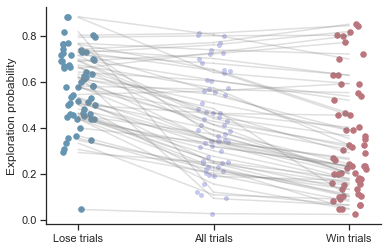

In [278]:
Exploration_0,Exploration_1,Total = exploration_exploitation()
sns.set(style='ticks')
sns.despine()
plt.figure(figsize=(6,4))
x0 = 1
x1 = 2
x2 = 3
x_lose = (np.random.random((60))-0.5)*0.25+np.ones((60))*x0
x_win = (np.random.random((60))-0.5)*0.25+np.ones((60))*x2
x = (np.random.random((60))-0.5)*0.25+np.ones((60))*x1
plt.scatter(x_lose,Exploration_0,s=30,color=(102/255,149/255,177/255))
plt.scatter(x,Total,s=15,color=(198/255, 200/255, 238/255))
plt.scatter(x_win,Exploration_1,s=30,color=(188/255,117/255,125/255))

# plt.scatter(np.zeros((60)),Exploration_0,s=15,color=(102/255,149/255,177/255))
# plt.scatter(np.ones((60)),Exploration_1,s=15,color=(188/255,117/255,125/255))
# plt.scatter(np.ones((60))*0.5,Total,s=5,color='lightgreen')

plt.xticks([x0,x1,x2],['Lose trials','All trials','Win trials'])
plt.ylabel('Exploration probability')
for i in range(60):
    plt.plot([x0,x1],[Exploration_0[i],Total[i]],c='grey',alpha=0.25)
    plt.plot([x1,x2],[Total[i],Exploration_1[i]],c='grey',alpha=0.25)
# print(get_p_value(Exploration_0,Exploration_1))
# for i in range(len(Total)):
#     if Total[i]<0.1:
#         print('subject: ',i+1,' the radio of exploration: ',Total[i])
Total = np.array(Total)
# print(np.mean(Total))
sns.despine()
plt.show()

In [282]:
t_val, p_val = ttest_rel(Exploration_0, Exploration_1)
print("Exploration_0 mean: ",np.mean(Exploration_0)," var :",np.var(Exploration_0))
print("Exploration_1 mean: ",np.mean(Exploration_1)," var :",np.var(Exploration_1))
print("t-test paired t-value: ",t_val," p-value: ",p_val)

Exploration_0 mean:  0.5797771179002364  var : 0.026070506232115983
Exploration_1 mean:  0.336438983411795  var : 0.05536636519618646
t-test paired t-value:  10.69195714076019  p-value:  1.975540869205123e-15


In [ ]:
s_llh = llh_s('./fitting_result/model_s.csv')
print('model_s llh: ',np.sum(s_llh))

glm2_e1p_llh = llh_glm2_e1p('./fitting_result/model_glm2_e1p.csv')
print('model_glm2_e1p llh: ',np.sum(glm2_e1p_llh))

model_s llh:  -8137.159843663665
model_glm2_e1p llh:  -7653.971597862855


In [12]:
s_loo = loo_s('./fitting_result/model_s.csv')
print('model_s loo: ',np.sum(s_loo))

glm2_e1p_loo = loo_glm2_e1p('./fitting_result/model_glm2_e1p.csv')
print('model_glm2_e1p loo: ',np.sum(glm2_e1p_loo))

model_s loo:  -8495.672030571306
model_glm2_e1p loo:  -9297.952350546031


In [44]:
v_loo = loo_v('./fitting_result/model_v.csv')
print('model_v loo: ',np.sum(v_loo))

ve_loo = loo_ve('./fitting_result/model_ve.csv')
print('model_ve loo: ',np.sum(ve_loo))

vp_loo = loo_vp('./fitting_result/model_vp.csv')
print('model_vp loo: ',np.sum(vp_loo))

vep_loo = loo_vep('./fitting_result/model_vep.csv')
print('model_vep loo: ',np.sum(vep_loo))

model_v loo:  -9067.660814109982
model_ve loo:  -9047.08479579122
model_vp loo:  -8541.579724246936
model_vep loo:  -8544.958864959048


In [12]:
v_llh = llh_v('./fitting_result/model_v.csv')
print('model_v llh: ',np.sum(v_llh))

ve_llh = llh_ve('./fitting_result/model_ve.csv')
print('model_ve llh: ',np.sum(ve_llh))

vp_llh = llh_vp('./fitting_result/model_vp.csv')
print('model_vp llh: ',np.sum(vp_llh))

vep_llh = llh_vep('./fitting_result/model_vep.csv')
print('model_vep llh: ',np.sum(vep_llh))

model_v llh:  -9008.20813908849
model_ve llh:  -8962.234571590438
model_vp llh:  -8423.67003186454
model_vep llh:  -8358.308622520326


In [45]:
glm_v_loo = loo_glm_v('./fitting_result/model_glm_v.csv')
print('model_glm_v loo: ',np.sum(glm_v_loo))

glm_e_loo = loo_glm_e('./fitting_result/model_glm_e.csv')
print('model_glm_e loo: ',np.sum(glm_e_loo))

glm_p_loo = loo_glm_p('./fitting_result/model_glm_p.csv')
print('model_glm_p loo: ',np.sum(glm_p_loo))

glm_ve_loo = loo_glm_ve('./fitting_result/model_glm_ve.csv')
print('model_glm_ve loo: ',np.sum(glm_ve_loo))

glm_vp_loo = loo_glm_vp('./fitting_result/model_glm_vp.csv')
print('model_glm_vp loo: ',np.sum(glm_vp_loo))

glm_ep_loo = loo_glm_ep('./fitting_result/model_glm_ep.csv')
print('model_glm_ep loo: ',np.sum(glm_ep_loo))

glm_vep_loo = loo_glm_vep('./fitting_result/model_glm_vep.csv')
print('model_glm_vep loo: ',np.sum(glm_vep_loo))

model_glm_v loo:  -8594.44769809122
model_glm_e loo:  -8386.6683405948
model_glm_p loo:  -8244.763001784167
model_glm_ve loo:  -9086.628315872007
model_glm_vp loo:  -8573.34533997896
model_glm_ep loo:  -8699.686671238609
model_glm_vep loo:  -9365.428166930895


In [23]:
glm_v_llh = llh_glm_v('./fitting_result/model_glm_v.csv')
print('model_glm_v llh: ',np.sum(glm_v_llh))

glm_e_llh = llh_glm_e('./fitting_result/model_glm_e.csv')
print('model_glm_e llh: ',np.sum(glm_e_llh))

glm_p_llh = llh_glm_p('./fitting_result/model_glm_p.csv')
print('model_glm_p llh: ',np.sum(glm_p_llh))

glm_ve_llh = llh_glm_ve('./fitting_result/model_glm_ve.csv')
print('model_glm_ve llh: ',np.sum(glm_ve_llh))

glm_vp_llh = llh_glm_vp('./fitting_result/model_glm_vp.csv')
print('model_glm_vp llh: ',np.sum(glm_vp_llh))

glm_ep_llh = llh_glm_ep('./fitting_result/model_glm_ep.csv')
print('model_glm_ep llh: ',np.sum(glm_ep_llh))

glm_vep_llh = llh_glm_vep('./fitting_result/model_glm_vep.csv')
print('model_glm_vep llh: ',np.sum(glm_vep_llh))

model_glm_v llh:  -8027.449883697864
model_glm_e llh:  -7793.665869340255
model_glm_p llh:  -7728.698148491011
model_glm_ve llh:  -7766.082262637378
model_glm_vp llh:  -7691.704618875172
model_glm_ep llh:  -7636.418665400668
model_glm_vep llh:  -7613.044560494566


In [46]:
glm2_v_loo = loo_glm2_v10('./fitting_result/model_glm2_v.csv')
print('model_glm2_v loo: ',np.sum(glm2_v_loo))

glm2_e_loo = loo_glm2_e10('./fitting_result/model_glm2_e.csv')
print('model_glm2_e loo: ',np.sum(glm2_e_loo))

glm2_p_loo = loo_glm2_p10('./fitting_result/model_glm2_p.csv')
print('model_glm2_p loo: ',np.sum(glm2_p_loo))

glm2_vep_loo = loo_glm2_vep('./fitting_result/model_glm2_vep.csv')
print('model_glm2_vep loo: ',np.sum(glm2_vep_loo))

model_glm2_v loo:  -17243.506343078563
model_glm2_e loo:  -9795.516492690349
model_glm2_p loo:  -8926.91844667314
model_glm2_vep loo:  -26323.928083257295


In [25]:
glm2_v_llh = llh_glm2_v('./fitting_result/model_glm2_v.csv')
print('model_glm2_v llh: ',np.sum(glm2_v_llh))

glm2_e_llh = llh_glm2_e('./fitting_result/model_glm2_e.csv')
print('model_glm2_e llh: ',np.sum(glm2_e_llh))

glm2_p_llh = llh_glm2_p('./fitting_result/model_glm2_p.csv')
print('model_glm2_p llh: ',np.sum(glm2_p_llh))

glm2_vep_llh = llh_glm2_vep('./fitting_result/model_glm2_vep.csv')
print('model_glm2_vep llh: ',np.sum(glm2_vep_llh))

model_glm2_v llh:  -8058.636978343231
model_glm2_e llh:  -7733.264412639464
model_glm2_p llh:  -7674.179956809106
model_glm2_vep llh:  -7598.925362503846


In [47]:
glm2_v0_loo = loo_glm2_v0('./fitting_result/model_glm2_v0.csv')
print('model_glm2_v0 loo: ',np.sum(glm2_v0_loo))

glm2_v1_loo = loo_glm2_v1('./fitting_result/model_glm2_v1.csv')
print('model_glm2_v1 loo: ',np.sum(glm2_v1_loo))

glm2_e0_loo = loo_glm2_e0('./fitting_result/model_glm2_e0.csv')
print('model_glm2_e0 loo: ',np.sum(glm2_e0_loo))

glm2_e1_loo = loo_glm2_e1('./fitting_result/model_glm2_e1.csv')
print('model_glm2_e1 loo: ',np.sum(glm2_e1_loo))

glm2_p0_loo = loo_glm2_p0('./fitting_result/model_glm2_p0.csv')
print('model_glm2_p0 loo: ',np.sum(glm2_p0_loo))

glm2_p1_loo = loo_glm2_p1('./fitting_result/model_glm2_p1.csv')
print('model_glm2_p1 loo: ',np.sum(glm2_p1_loo))

model_glm2_v0 loo:  -15139.860370286253
model_glm2_v1 loo:  -10511.695693063166
model_glm2_e0 loo:  -8616.592870498125
model_glm2_e1 loo:  -8388.866321779358
model_glm2_p0 loo:  -8360.089829708551
model_glm2_p1 loo:  -8364.442548616502


In [32]:
glm2_v0_llh = llh_glm2_v0('./fitting_result/model_glm2_v0.csv')
print('model_glm2_v0 llh: ',np.sum(glm2_v0_llh))

glm2_v1_llh = llh_glm2_v1('./fitting_result/model_glm2_v1.csv')
print('model_glm2_v1 llh: ',np.sum(glm2_v1_llh))

glm2_e0_llh = llh_glm2_e0('./fitting_result/model_glm2_e0.csv')
print('model_glm2_e0 llh: ',np.sum(glm2_e0_llh))

glm2_e1_llh = llh_glm2_e1('./fitting_result/model_glm2_e1.csv')
print('model_glm2_e1 llh: ',np.sum(glm2_e1_llh))

glm2_p0_llh = llh_glm2_p0('./fitting_result/model_glm2_p0.csv')
print('model_glm2_p0 llh: ',np.sum(glm2_p0_llh))

glm2_p1_llh = llh_glm2_p1('./fitting_result/model_glm2_p1.csv')
print('model_glm2_p1 llh: ',np.sum(glm2_p1_llh))

model_glm2_v0 llh:  -8120.554979548586
model_glm2_v1 llh:  -8029.944854523886
model_glm2_e0 llh:  -7850.118712251267
model_glm2_e1 llh:  -7829.967101290866
model_glm2_p0 llh:  -7771.929099756871
model_glm2_p1 llh:  -7795.758962996128


In [48]:
glm2_v0e0_loo = loo_glm2_v0e0('./fitting_result/model_glm2_v0e0.csv')
print('model_glm2_v0e0 loo: ',np.sum(glm2_v0e0_loo))

glm2_v1e1_loo = loo_glm2_v1e1('./fitting_result/model_glm2_v1e1.csv')
print('model_glm2_v1e1 loo: ',np.sum(glm2_v1e1_loo))

glm2_e0p0_loo = loo_glm2_e0p0('./fitting_result/model_glm2_e0p0.csv')
print('model_glm2_e0p0 loo: ',np.sum(glm2_e0p0_loo))

glm2_e1p1_loo = loo_glm2_e1p1('./fitting_result/model_glm2_e1p1.csv')
print('model_glm2_e1p1 loo: ',np.sum(glm2_e1p1_loo))

glm2_v0p0_loo = loo_glm2_v0p0('./fitting_result/model_glm2_v0p0.csv')
print('model_glm2_v0p0 loo: ',np.sum(glm2_v0p0_loo))

glm2_v1p1_loo = loo_glm2_v1p1('./fitting_result/model_glm2_v1p1.csv')
print('model_glm2_v1p1 loo: ',np.sum(glm2_v1p1_loo))

glm2_v0e0p0_loo = loo_glm2_v0e0p0('./fitting_result/model_glm2_v0e0p0.csv')
print('model_glm2_v0e0p0 loo: ',np.sum(glm2_v0e0p0_loo))

glm2_v1e1p1_loo = loo_glm2_v1e1p1('./fitting_result/model_glm2_v1e1p1.csv')
print('model_glm2_v1e1p1 loo: ',np.sum(glm2_v1e1p1_loo))


model_glm2_v0e0 loo:  -15306.296097034372
model_glm2_v1e1 loo:  -12142.586410415468
model_glm2_e0p0 loo:  -9029.111055149346
model_glm2_e1p1 loo:  -9357.983829677536
model_glm2_v0p0 loo:  -15647.826981269705
model_glm2_v1p1 loo:  -12035.453683025311
model_glm2_v0e0p0 loo:  -16407.273417962733
model_glm2_v1e1p1 loo:  -14226.938659958916


In [34]:
glm2_v0e0_llh = llh_glm2_v0e0('./fitting_result/model_glm2_v0e0.csv')
print('model_glm2_v0e0 llh: ',np.sum(glm2_v0e0_llh))

glm2_v1e1_llh = llh_glm2_v1e1('./fitting_result/model_glm2_v1e1.csv')
print('model_glm2_v1e1 llh: ',np.sum(glm2_v1e1_llh))

glm2_e0p0_llh = llh_glm2_e0p0('./fitting_result/model_glm2_e0p0.csv')
print('model_glm2_e0p0 llh: ',np.sum(glm2_e0p0_llh))

glm2_e1p1_llh = llh_glm2_e1p1('./fitting_result/model_glm2_e1p1.csv')
print('model_glm2_e1p1 llh: ',np.sum(glm2_e1p1_llh))

glm2_v0p0_llh = llh_glm2_v0p0('./fitting_result/model_glm2_v0p0.csv')
print('model_glm2_v0p0 llh: ',np.sum(glm2_v0p0_llh))

glm2_v1p1_llh = llh_glm2_v1p1('./fitting_result/model_glm2_v1p1.csv')
print('model_glm2_v1p1 llh: ',np.sum(glm2_v1p1_llh))

glm2_v0e0p0_llh = llh_glm2_v0e0p0('./fitting_result/model_glm2_v0e0p0.csv')
print('model_glm2_v0e0p0 llh: ',np.sum(glm2_v0e0p0_llh))

glm2_v1e1p1_llh = llh_glm2_v1e1p1('./fitting_result/model_glm2_v1e1p1.csv')
print('model_glm2_v1e1p1 llh: ',np.sum(glm2_v1e1p1_llh))

model_glm2_v0e0 llh:  -7865.630071085486
model_glm2_v1e1 llh:  -7830.283554590403
model_glm2_e0p0 llh:  -7685.341064966501
model_glm2_e1p1 llh:  -7714.370366893378
model_glm2_v0p0 llh:  -7776.74680148969
model_glm2_v1p1 llh:  -7810.188705836246
model_glm2_v0e0p0 llh:  -7713.635408484556
model_glm2_v1e1p1 llh:  -7725.663719655072


In [49]:
glm2_v1e1p0_loo = loo_glm2_v1e1p0('./fitting_result/model_glm2_v1e1p0.csv')
print('model_glm2_v1e1p0 loo: ',np.sum(glm2_v1e1p0_loo))

model_glm2_v1e1p0 loo:  -13272.40694803187


In [39]:
glm2_v1e1p0_llh = llh_glm2_v1e1p0('./fitting_result/model_glm2_v1e1p0.csv')
print('model_glm2_v1e1p0 llh: ',np.sum(glm2_v1e1p0_llh))

model_glm2_v1e1p0 llh:  -7666.395361807456


In [ ]:
'v, ve, vp, vep'
'glm_v, glm_e, glm_p, glm_ve, glm_vp, glm_ep, glm_vep'
'glm2_v, glm2_e, glm2_p, glm2_vep'
'glm2_v1, glm2_v0, glm2_e1, glm2_e0, glm2_p1, glm2_p0'
'glm2_v1e1, glm2_v0e0, glm2_v1p1, glm2_v0p0, glm2_e1p1, glm2_e0p0'
'glm2_v1e1p1, glm2_v0e0p0, glm2_v1e1p0'

In [50]:
print('model_v llh: ',round(np.sum(v_llh),3),', BIC:', round(calculate_bic(np.sum(v_llh), 1),3), ', AIC:', round(calculate_aic(np.sum(v_llh), 1),3), ', loo:',round(np.sum( v_loo),3))
print('model_ve llh: ',round(np.sum(ve_llh),3),', BIC:', round(calculate_bic(np.sum(ve_llh), 2),3), ', AIC:', round(calculate_aic(np.sum(ve_llh), 2),3), ', loo:',round(np.sum( ve_loo),3))
print('model_vp llh: ',round(np.sum(vp_llh),3),', BIC:', round(calculate_bic(np.sum(vp_llh), 2),3), ', AIC:', round(calculate_aic(np.sum(vp_llh), 2),3), ', loo:',round(np.sum( vp_loo),3))
print('model_vep llh: ',round(np.sum(vep_llh),3),', BIC:', round(calculate_bic(np.sum(vep_llh), 3),3), ', AIC:', round(calculate_aic(np.sum(vep_llh), 3),3), ', loo:',round(np.sum( vep_loo),3))
print('model_glm_v llh: ',round(np.sum(glm_v_llh),3),', BIC:', round(calculate_bic(np.sum(glm_v_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm_v_llh), 4),3), ', loo:',round(np.sum( glm_v_loo),3))
print('model_glm_e llh: ',round(np.sum(glm_e_llh),3),', BIC:', round(calculate_bic(np.sum(glm_e_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm_e_llh), 4),3), ', loo:',round(np.sum( glm_e_loo),3))
print('model_glm_p llh: ',round(np.sum(glm_p_llh),3),', BIC:', round(calculate_bic(np.sum(glm_p_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm_p_llh), 4),3), ', loo:',round(np.sum( glm_p_loo),3))
print('model_glm_ve llh: ',round(np.sum(glm_ve_llh),3),', BIC:', round(calculate_bic(np.sum(glm_ve_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm_ve_llh), 5),3), ', loo:',round(np.sum( glm_ve_loo),3))
print('model_glm_vp llh: ',round(np.sum(glm_vp_llh),3),', BIC:', round(calculate_bic(np.sum(glm_vp_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm_vp_llh), 5),3), ', loo:',round(np.sum( glm_vp_loo),3))
print('model_glm_ep llh: ',round(np.sum(glm_ep_llh),3),', BIC:', round(calculate_bic(np.sum(glm_ep_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm_ep_llh), 5),3), ', loo:',round(np.sum( glm_ep_loo),3))
print('model_glm_vep llh: ',round(np.sum(glm_vep_llh),3),', BIC:', round(calculate_bic(np.sum(glm_vep_llh), 6),3), ', AIC:', round(calculate_aic(np.sum(glm_vep_llh), 6),3), ', loo:',round(np.sum( glm_vep_loo),3))
print('model_glm2_v llh: ',round(np.sum(glm2_v_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v_llh), 5),3), ', loo:',round(np.sum( glm2_v_loo),3))
print('model_glm2_e llh: ',round(np.sum(glm2_e_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_e_llh), 5),3), ', loo:',round(np.sum( glm2_e_loo),3))
print('model_glm2_p llh: ',round(np.sum(glm2_p_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_p_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_p_llh), 5),3), ', loo:',round(np.sum( glm2_p_loo),3))
print('model_glm2_vep llh: ',round(np.sum(glm2_vep_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_vep_llh), 9),3), ', AIC:', round(calculate_aic(np.sum(glm2_vep_llh), 9),3), ', loo:',round(np.sum( glm2_vep_loo),3))
print('model_glm2_v1 llh: ',round(np.sum(glm2_v1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1_llh), 4),3), ', loo:',round(np.sum( glm2_v1_loo),3))
print('model_glm2_v0 llh: ',round(np.sum(glm2_v0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v0_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_v0_llh), 4),3), ', loo:',round(np.sum( glm2_v0_loo),3))
print('model_glm2_e1 llh: ',round(np.sum(glm2_e1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e1_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_e1_llh), 4),3), ', loo:',round(np.sum( glm2_e1_loo),3))
print('model_glm2_e0 llh: ',round(np.sum(glm2_e0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e0_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_e0_llh), 4),3), ', loo:',round(np.sum( glm2_e0_loo),3))
print('model_glm2_p1 llh: ',round(np.sum(glm2_p1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_p1_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_p1_llh), 4),3), ', loo:',round(np.sum( glm2_p1_loo),3))
print('model_glm2_p0 llh: ',round(np.sum(glm2_p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_p0_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(glm2_p0_llh), 4),3), ', loo:',round(np.sum( glm2_p0_loo),3))
print('model_glm2_v1e1 llh: ',round(np.sum(glm2_v1e1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1e1_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1e1_llh), 5),3), ', loo:',round(np.sum( glm2_v1e1_loo),3))
print('model_glm2_v0e0 llh: ',round(np.sum(glm2_v0e0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v0e0_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v0e0_llh), 5),3), ', loo:',round(np.sum( glm2_v0e0_loo),3))
print('model_glm2_v1p1 llh: ',round(np.sum(glm2_v1p1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1p1_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1p1_llh), 5),3), ', loo:',round(np.sum( glm2_v1p1_loo),3))
print('model_glm2_v0p0 llh: ',round(np.sum(glm2_v0p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v0p0_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_v0p0_llh), 5),3), ', loo:',round(np.sum( glm2_v0p0_loo),3))
print('model_glm2_e1p1 llh: ',round(np.sum(glm2_e1p1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e1p1_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_e1p1_llh), 5),3), ', loo:',round(np.sum( glm2_e1p1_loo),3))
print('model_glm2_e0p0 llh: ',round(np.sum(glm2_e0p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_e0p0_llh), 5),3), ', AIC:', round(calculate_aic(np.sum(glm2_e0p0_llh), 5),3), ', loo:',round(np.sum( glm2_e0p0_loo),3))
print('model_glm2_v1e1p1 llh: ',round(np.sum(glm2_v1e1p1_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1e1p1_llh), 6),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1e1p1_llh), 6),3), ', loo:',round(np.sum( glm2_v1e1p1_loo),3))
print('model_glm2_v0e0p0 llh: ',round(np.sum(glm2_v0e0p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v0e0p0_llh), 6),3), ', AIC:', round(calculate_aic(np.sum(glm2_v0e0p0_llh), 6),3), ', loo:',round(np.sum( glm2_v0e0p0_loo),3))
print('model_glm2_v1e1p0 llh: ',round(np.sum(glm2_v1e1p0_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_v1e1p0_llh), 6),3), ', AIC:', round(calculate_aic(np.sum(glm2_v1e1p0_llh), 6),3), ', loo:',round(np.sum( glm2_v1e1p0_loo),3))

model_v llh:  -9008.208 , BIC: 18025.521 , AIC: 18018.416 , loo: -9067.661
model_ve llh:  -8962.235 , BIC: 17942.679 , AIC: 17928.469 , loo: -9047.085
model_vp llh:  -8423.67 , BIC: 16865.55 , AIC: 16851.34 , loo: -8541.58
model_vep llh:  -8358.309 , BIC: 16743.932 , AIC: 16722.617 , loo: -8544.959
model_glm_v llh:  -8027.45 , BIC: 16091.32 , AIC: 16062.9 , loo: -8594.448
model_glm_e llh:  -7793.666 , BIC: 15623.752 , AIC: 15595.332 , loo: -8386.668
model_glm_p llh:  -7728.698 , BIC: 15493.816 , AIC: 15465.396 , loo: -8244.763
model_glm_ve llh:  -7766.082 , BIC: 15577.689 , AIC: 15542.165 , loo: -9086.628
model_glm_vp llh:  -7691.705 , BIC: 15428.934 , AIC: 15393.409 , loo: -8573.345
model_glm_ep llh:  -7636.419 , BIC: 15318.362 , AIC: 15282.837 , loo: -8699.687
model_glm_vep llh:  -7613.045 , BIC: 15280.719 , AIC: 15238.089 , loo: -9365.428
model_glm2_v llh:  -8058.637 , BIC: 16162.799 , AIC: 16127.274 , loo: -17243.506
model_glm2_e llh:  -7733.264 , BIC: 15512.054 , AIC: 15476.529 , 

In [84]:
glm_vep_llh = llh_glm_vep('./fitting_result/model_glm_vep.csv')
glm_vep_old_llh = llh_glm_vep('./fitting_result/model_glm_vep_old.csv')
print('model_glm_vep llh: ',np.sum(glm_vep_llh))
print('model_glm_vep_old llh: ',np.sum(glm_vep_old_llh))

model_glm_vep llh:  -7613.044560494566
model_glm_vep_old llh:  -7602.412677185822


In [83]:
glm2_vep_llh = llh_glm2_vep('./fitting_result/model_glm2_vep.csv')
glm2_vep_old_llh = llh_glm2_vep('./fitting_result/model_glm2_vep_old.csv')
print('model_glm2_vep llh: ',np.sum(glm2_vep_llh))
print('model_glm2_vep_old llh: ',np.sum(glm2_vep_old_llh))

model_glm2_vep llh:  -7598.925362503846
model_glm2_vep_old llh:  -7489.551531332412


In [306]:
glm2_vep_llh = llh_glm2_vep('./fitting_result/model_glm2_vep.csv')
glm2_vep_add_iter_llh = llh_glm2_vep('./fitting_result/model_glm2_vep_add_iter.csv')
glm2_vep_old = llh_glm2_vep('./fitting_result/model_glm2_vep_old.csv')
glm2_vep_no_betat_llh = llh_glm2_vep('./fitting_result/model_glm2_vep_no_betat.csv')
glm2_vep_no_betat_no_betat_llh = llh_glm2_vep_no_betat('./fitting_result/model_glm2_vep_no_betat.csv')
print('model_glm2_vep llh: ',np.sum(glm2_vep_llh))
print('model_glm2_vep_add_iter llh: ',np.sum(glm2_vep_add_iter_llh))
print('model_glm2_vep_old llh: ',np.sum(glm2_vep_old))
print('model_glm2_vep_no_betat llh: ',np.sum(glm2_vep_no_betat_llh))
print('model_glm2_vep_no_betat_no_betat llh: ',np.sum(glm2_vep_no_betat_no_betat_llh))

model_glm2_vep llh:  -7590.490401630555
model_glm2_vep_add_iter llh:  -7592.030892490311
model_glm2_vep_old llh:  -7489.551531332412
model_glm2_vep_no_betat llh:  -7492.5585914663525
model_glm2_vep_no_betat_no_betat llh:  -7471.404660313333


In [ ]:
glm2_vep_no_betat_llh = llh_glm2_vep('./fitting_result/model_glm2_vep_no_betat.csv')
glm2_vep_no_betat_loo = loo_glm2_vep('./fitting_result/model_glm2_vep_no_betat.csv')


model_glm2_vep llh:  -7598.925 , BIC: 15279.796 , AIC: 15215.851 , loo: -26323.928


In [307]:
print('model_glm2_vep_no_betat llh: ',round(np.sum(glm2_vep_no_betat_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_vep_no_betat_llh), 9),3), ', AIC:', round(calculate_aic(np.sum(glm2_vep_no_betat_llh), 9),3), ', loo:',round(np.sum( glm2_vep_no_betat_loo),3))

model_glm2_vep_no_betat llh:  -7492.559 , BIC: 15067.062 , AIC: 15003.117 , loo: -16290.025


In [ ]:
glm2_ep_llh = llh_glm2_ep('./fitting_result/model_glm2_ep.csv')
glm2_ep_loo = loo_glm2_ep('./fitting_result/model_glm2_ep.csv')

In [303]:
print('model_glm2_ep llh: ',round(np.sum(glm2_ep_llh),3),', BIC:', round(calculate_bic(np.sum(glm2_ep_llh), 7),3), ', AIC:', round(calculate_aic(np.sum(glm2_ep_llh), 7),3), ', loo:',round(np.sum( glm2_ep_loo),3))

model_glm2_ep llh:  -7543.846 , BIC: 15151.426 , AIC: 15101.691 , loo: -13164.6


In [308]:
print('model_s llh: ',round(np.sum(s_llh),3),', BIC:', round(calculate_bic(np.sum(s_llh), 4),3), ', AIC:', round(calculate_aic(np.sum(s_llh), 4),3), ', loo:',round(np.sum( s_loo),3))

model_s llh:  -8137.16 , BIC: 16310.74 , AIC: 16282.32 , loo: -8495.672


In [283]:
beta_a,phi_a,persev_a,beta_b,phi_b,persev_b = read_parameter_6_para('./fitting_result/model_glm_vep.csv')

beta_norm = np.divide(beta_a,beta_b)
phi_norm = np.divide(phi_a,phi_b)
persev_norm = np.divide(persev_a,persev_b)

beta_norm_abs = np.divide(beta_a,np.abs(beta_b))
phi_norm_abs = np.divide(phi_a,np.abs(phi_b))
persev_norm_abs = np.divide(persev_a,np.abs(persev_b))

data_glm_vep = {'beta_a':beta_a,'phi_a':phi_a,'persev_a':persev_a,
        'beta_b':beta_b,'phi_b':phi_b,'persev_b':persev_b,
        'beta_norm':beta_norm,'phi_norm':phi_norm,'persev_norm':persev_norm,
        'beta_norm_abs':beta_norm_abs,'phi_norm_abs':phi_norm_abs,'persev_norm_abs':persev_norm_abs}

df_glm_vep = pd.DataFrame(data_glm_vep)

print("beta_a: ", round(np.mean(beta_a),3)," phi_a: ", round(np.mean(phi_a),3)," persev_a: ", round(np.mean(persev_a),3))
print("beta_b: ", round(np.mean(beta_b),3)," phi_b: ", round(np.mean(phi_b),3)," persev_b: ", round(np.mean(persev_b),3))
print("beta_norm: ", round(np.mean(beta_norm),3)," phi_norm: ", round(np.mean(phi_norm),3)," persev_norm: ", round(np.mean(persev_norm),3))
print("beta_norm_abs: ", round(np.mean(beta_norm_abs),3)," phi_norm_abs: ", round(np.mean(phi_norm_abs),3)," persev_norm_abs: ", round(np.mean(persev_norm_abs),3))

beta_a:  0.002  phi_a:  -0.022  persev_a:  0.148
beta_b:  0.049  phi_b:  -0.066  persev_b:  0.265
beta_norm:  0.079  phi_norm:  -0.149  persev_norm:  0.204
beta_norm_abs:  0.079  phi_norm_abs:  -0.511  persev_norm_abs:  0.266


In [105]:
t_stat, p_value = ttest_1samp(df_glm_vep["beta_a"], 0)
if p_value < 0.05:
    print("beta_a 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("beta_a分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["phi_a"], 0)
if p_value < 0.05:
    print("phi_a 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("phi_a分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["persev_a"], 0)
if p_value < 0.05:
    print("persev_a 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("persev_a分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["beta_norm_abs"], 0)
if p_value < 0.05:
    print("beta_norm_abs 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("beta_norm_abs分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["phi_norm_abs"], 0)
if p_value < 0.05:
    print("phi_norm_abs 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("phi_norm_abs分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

t_stat, p_value = ttest_1samp(df_glm_vep["persev_norm_abs"], 0)
if p_value < 0.05:
    print("persev_norm_abs 分布与0有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("persev_norm_abs分布与0没有显著差异")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

beta_a分布与0没有显著差异
T-statistic: 1.5733, P-value: 0.1210
phi_a 分布与0有显著差异
T-statistic: -6.1746, P-value: 0.0000
persev_a 分布与0有显著差异
T-statistic: 5.4505, P-value: 0.0000
beta_norm_abs 分布与0有显著差异
T-statistic: 2.5344, P-value: 0.0139
phi_norm_abs 分布与0有显著差异
T-statistic: -2.3745, P-value: 0.0208
persev_norm_abs分布与0没有显著差异
T-statistic: 1.1313, P-value: 0.2625


In [284]:
print('beta_a: ', np.mean(beta_a), np.median(beta_a), np.var(beta_a),ttest_1samp(df_glm_vep["beta_a"], 0)[0], ttest_1samp(df_glm_vep["beta_a"], 0)[1])
print('phi_a: ', np.mean(phi_a), np.median(phi_a), np.var(phi_a),ttest_1samp(df_glm_vep["phi_a"], 0)[0], ttest_1samp(df_glm_vep["phi_a"], 0)[1])
print('persev_a: ', np.mean(persev_a), np.median(persev_a), np.var(persev_a),ttest_1samp(df_glm_vep["persev_a"], 0)[0], ttest_1samp(df_glm_vep["persev_a"], 0)[1])

print('beta_norm_abs: ', np.mean(beta_norm_abs), np.median(beta_norm_abs), np.var(beta_norm_abs),ttest_1samp(df_glm_vep["beta_norm_abs"], 0)[0], ttest_1samp(df_glm_vep["beta_norm_abs"], 0)[1])
print('phi_norm_abs: ', np.mean(phi_norm_abs), np.median(phi_norm_abs), np.var(phi_norm_abs),ttest_1samp(df_glm_vep["phi_norm_abs"], 0)[0], ttest_1samp(df_glm_vep["phi_norm_abs"], 0)[1])
print('persev_norm_abs: ', np.mean(persev_norm_abs), np.median(persev_norm_abs), np.var(persev_norm_abs),ttest_1samp(df_glm_vep["persev_norm_abs"], 0)[0], ttest_1samp(df_glm_vep["persev_norm_abs"], 0)[1])

beta_a:  0.0016700973685393966 0.0009171010194809 6.648254404905921e-05 1.573308838952873 0.12099502891054174
phi_a:  -0.021771633299773812 -0.018490773588340052 0.0007335206837450859 -6.174628518129191 6.6229260285576e-08
persev_a:  0.14840850039825468 0.13863436440712756 0.043741135730853 5.4505428088071985 1.0332806597951994e-06
beta_norm_abs:  0.0785482650405102 0.03309572217782984 0.05667086833393612 2.534443821684822 0.01393618185053162
phi_norm_abs:  -0.510910115680297 -0.2019606107034933 2.7314621027873875 -2.374504066387299 0.020843982154095497
persev_norm_abs:  0.26614447239147737 0.17903828558118656 3.2651217944193287 1.1313416180306333 0.26248897057243353


In [ ]:
for i in range(len(beta_a)):
    if persev_a[i] <-10:
        print(i)

In [49]:
print(np.mean(df_glm_vep["beta_a"]))
print(np.mean(df_glm_vep["phi_a"]))
print(np.mean(df_glm_vep["persev_a"]))

0.0016700973685393966
-0.021771633299773812
0.14840850039825468


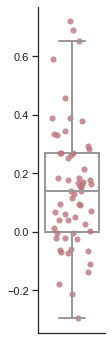

In [57]:
x = (np.random.random((60))-np.ones((60))*0.5)*0.6
plt.figure(figsize=(1.2,6))
sns.boxplot(data=df_glm_vep["persev_a"],linewidth=2,fliersize=0,color='white')
plt.scatter(x,persev_a,s=30,color=(188/255,117/255,125/255),linewidths=0.5,alpha=0.8)
# plt.yticks([-3,-2,-1,0,1,2])
plt.xticks([])
# plt.ylim([-4,2])
sns.set(style='ticks')
sns.despine()

In [58]:
beta_a,beta_b,_,_ = read_parameter_4_para('./fitting_result/model_glm_v.csv')
phi_a,_,phi_b,_ = read_parameter_4_para('./fitting_result/model_glm_e.csv')
persev_a,_,_,persev_b = read_parameter_4_para('./fitting_result/model_glm_p.csv')

beta_norm = np.divide(beta_a,beta_b)
phi_norm = np.divide(phi_a,phi_b)
persev_norm = np.divide(persev_a,persev_b)

beta_norm_abs = np.divide(beta_a,np.abs(beta_b))
phi_norm_abs = np.divide(phi_a,np.abs(phi_b))
persev_norm_abs = np.divide(persev_a,np.abs(persev_b))

data_glm_1_para = {'beta_a':beta_a,'phi_a':phi_a,'persev_a':persev_a,
        'beta_b':beta_b,'phi_b':phi_b,'persev_b':persev_b,
        'beta_norm':beta_norm,'phi_norm':phi_norm,'persev_norm':persev_norm,
        'beta_norm_abs':beta_norm_abs,'phi_norm_abs':phi_norm_abs,'persev_norm_abs':persev_norm_abs}

df_1_para = pd.DataFrame(data_glm_1_para)

print("beta_a: ", round(np.mean(beta_a),3)," phi_a: ", round(np.mean(phi_a),3)," persev_a: ", round(np.mean(persev_a),3))
print("beta_b: ", round(np.mean(beta_b),3)," phi_b: ", round(np.mean(phi_b),3)," persev_b: ", round(np.mean(persev_b),3))
print("beta_norm: ", round(np.mean(beta_norm),3)," phi_norm: ", round(np.mean(phi_norm),3)," persev_norm: ", round(np.mean(persev_norm),3))
print("beta_norm_abs: ", round(np.mean(beta_norm_abs),3)," phi_norm_abs: ", round(np.mean(phi_norm_abs),3)," persev_norm_abs: ", round(np.mean(persev_norm_abs),3))

beta_a:  0.009  phi_a:  -0.038  persev_a:  0.229
beta_b:  0.063  phi_b:  -0.089  persev_b:  0.385
beta_norm:  0.205  phi_norm:  0.117  persev_norm:  0.181
beta_norm_abs:  0.205  phi_norm_abs:  -0.545  persev_norm_abs:  0.41


In [60]:
print('beta_a: ', np.mean(beta_a), np.median(beta_a), np.var(beta_a),ttest_1samp(beta_a, 0)[0], ttest_1samp(beta_a, 0)[1])
print('phi_a: ', np.mean(phi_a), np.median(phi_a), np.var(phi_a),ttest_1samp(phi_a, 0)[0], ttest_1samp(phi_a, 0)[1])
print('persev_a: ', np.mean(persev_a), np.median(persev_a), np.var(persev_a),ttest_1samp(persev_a, 0)[0], ttest_1samp(persev_a, 0)[1])

print('beta_norm_abs: ', np.mean(beta_norm_abs), np.median(beta_norm_abs), np.var(beta_norm_abs),ttest_1samp(beta_norm_abs, 0)[0], ttest_1samp(beta_norm_abs, 0)[1])
print('phi_norm_abs: ', np.mean(phi_norm_abs), np.median(phi_norm_abs), np.var(phi_norm_abs),ttest_1samp(phi_norm_abs, 0)[0], ttest_1samp(phi_norm_abs, 0)[1])
print('persev_norm_abs: ', np.mean(persev_norm_abs), np.median(persev_norm_abs), np.var(persev_norm_abs),ttest_1samp(persev_norm_abs, 0)[0], ttest_1samp(persev_norm_abs, 0)[1])

beta_a:  0.009466010499278274 0.0063389768923974 8.181583842538709e-05 8.038486653272225 4.7103970238068514e-11
phi_a:  -0.03801359544804252 -0.04003767914447805 0.0008123211054799387 -10.244743416219976 1.031318032367086e-14
persev_a:  0.22875805614766487 0.21690465506800072 0.03541973615319157 9.336406288472283 3.156266608798827e-13
beta_norm_abs:  0.20528287001394496 0.11504767695561172 0.06277123416033259 6.293589069844693 4.19037857598029e-08
phi_norm_abs:  -0.5448352418338923 -0.278580453352837 0.708990657550308 -4.970166537536191 6.072658264267233e-06
persev_norm_abs:  0.4098644225298031 0.2523130381095491 0.29793811040847057 5.767707107610433 3.1310578531919964e-07


In [270]:
phi_a_1,persev_a_1,beta_b,phi_b,persev_b = read_parameter_5_para('./fitting_result/model_glm2_e1p1.csv')
phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_5_para('./fitting_result/model_glm2_e0p0.csv')


d_phi_a = phi_a_1 - phi_a_0
d_persev_a = persev_a_1 - persev_a_0


phi_1_norm_abs = np.divide(phi_a_1,np.abs(phi_b))
persev_1_norm_abs = np.divide(persev_a_1,np.abs(persev_b))


phi_0_norm_abs = np.divide(phi_a_0,np.abs(phi_b))
persev_0_norm_abs = np.divide(persev_a_0,np.abs(persev_b))

data_glm2_ep = {'phi_a_1':phi_a_1,'persev_a_1':persev_a_1,
                 'phi_a_0':phi_a_0,'persev_a_0':persev_a_0,
                 'beta_b':beta_b,'phi_b':phi_b,'persev_b':persev_b,
                 'd_phi_a':d_phi_a,'d_persev_a':d_persev_a,
                 'phi_1_norm_abs':phi_1_norm_abs,'persev_1_norm_abs':persev_1_norm_abs,
                 'phi_0_norm_abs':phi_0_norm_abs,'persev_0_norm_abs':persev_0_norm_abs}

df_glm2_ep = pd.DataFrame(data_glm2_ep)

print(" phi_a_1: ", round(np.mean(phi_a_1),3),round(np.var(phi_a_1),3)," persev_a_1: ", round(np.mean(persev_a_1),3),round(np.var(persev_a_1),3))
print(" phi_a_0: ", round(np.mean(phi_a_0),3),round(np.var(phi_a_0),3)," persev_a_0: ", round(np.mean(persev_a_0),3),round(np.var(persev_a_0),3))
print("beta_b: ", round(np.mean(beta_b),3)," phi_b: ", round(np.mean(phi_b),3)," persev_b: ", round(np.mean(persev_b),3))
print(" phi_1_norm_abs: ", round(np.mean(phi_1_norm_abs),3)," persev_1_norm_abs: ", round(np.mean(persev_1_norm_abs),3))
print(" phi_0_norm_abs: ", round(np.mean(phi_0_norm_abs),3)," persev_0_norm_abs: ", round(np.mean(persev_0_norm_abs),3))

 phi_a_1:  -0.04 0.002  persev_a_1:  0.245 0.13
 phi_a_0:  -0.032 0.001  persev_a_0:  0.304 0.125
beta_b:  0.051  phi_b:  -0.107  persev_b:  0.706
 phi_1_norm_abs:  0.199  persev_1_norm_abs:  0.31
 phi_0_norm_abs:  0.511  persev_0_norm_abs:  0.225


In [273]:
phi_a_1,persev_a_1,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_7_para('./fitting_result/model_glm2_ep.csv')


d_phi_a = phi_a_1 - phi_a_0
d_persev_a = persev_a_1 - persev_a_0


phi_1_norm_abs = np.divide(phi_a_1,np.abs(phi_b))
persev_1_norm_abs = np.divide(persev_a_1,np.abs(persev_b))


phi_0_norm_abs = np.divide(phi_a_0,np.abs(phi_b))
persev_0_norm_abs = np.divide(persev_a_0,np.abs(persev_b))

data_glm2_ep = {'phi_a_1':phi_a_1,'persev_a_1':persev_a_1,
                 'phi_a_0':phi_a_0,'persev_a_0':persev_a_0,
                 'beta_b':beta_b,'phi_b':phi_b,'persev_b':persev_b,
                 'd_phi_a':d_phi_a,'d_persev_a':d_persev_a,
                 'phi_1_norm_abs':phi_1_norm_abs,'persev_1_norm_abs':persev_1_norm_abs,
                 'phi_0_norm_abs':phi_0_norm_abs,'persev_0_norm_abs':persev_0_norm_abs}

df_glm2_ep = pd.DataFrame(data_glm2_ep)

print(" phi_a_1: ", round(np.mean(phi_a_1),3),round(np.var(phi_a_1),3)," persev_a_1: ", round(np.mean(persev_a_1),3),round(np.var(persev_a_1),3))
print(" phi_a_0: ", round(np.mean(phi_a_0),3),round(np.var(phi_a_0),3)," persev_a_0: ", round(np.mean(persev_a_0),3),round(np.var(persev_a_0),3))
print("beta_b: ", round(np.mean(beta_b),3)," phi_b: ", round(np.mean(phi_b),3)," persev_b: ", round(np.mean(persev_b),3))
print(" phi_1_norm_abs: ", round(np.mean(phi_1_norm_abs),3)," persev_1_norm_abs: ", round(np.mean(persev_1_norm_abs),3))
print(" phi_0_norm_abs: ", round(np.mean(phi_0_norm_abs),3)," persev_0_norm_abs: ", round(np.mean(persev_0_norm_abs),3))

 phi_a_1:  -0.025 0.002  persev_a_1:  0.134 0.107
 phi_a_0:  -0.023 0.002  persev_a_0:  0.2 0.087
beta_b:  0.049  phi_b:  -0.072  persev_b:  0.364
 phi_1_norm_abs:  -0.94  persev_1_norm_abs:  0.464
 phi_0_norm_abs:  -0.248  persev_0_norm_abs:  0.362


In [275]:
phi_a_1,phi_a_0,beta_b,phi_b,persev_b = read_parameter_5_para('./fitting_result/model_glm2_e.csv')
persev_a_1,persev_a_0,beta_b,phi_b,persev_b = read_parameter_5_para('./fitting_result/model_glm2_p.csv')


d_phi_a = phi_a_1 - phi_a_0
d_persev_a = persev_a_1 - persev_a_0


phi_1_norm_abs = np.divide(phi_a_1,np.abs(phi_b))
persev_1_norm_abs = np.divide(persev_a_1,np.abs(persev_b))


phi_0_norm_abs = np.divide(phi_a_0,np.abs(phi_b))
persev_0_norm_abs = np.divide(persev_a_0,np.abs(persev_b))

data_glm2_ep = {'phi_a_1':phi_a_1,'persev_a_1':persev_a_1,
                 'phi_a_0':phi_a_0,'persev_a_0':persev_a_0,
                 'beta_b':beta_b,'phi_b':phi_b,'persev_b':persev_b,
                 'd_phi_a':d_phi_a,'d_persev_a':d_persev_a,
                 'phi_1_norm_abs':phi_1_norm_abs,'persev_1_norm_abs':persev_1_norm_abs,
                 'phi_0_norm_abs':phi_0_norm_abs,'persev_0_norm_abs':persev_0_norm_abs}

df_glm2_ep = pd.DataFrame(data_glm2_ep)

print(" phi_a_1: ", round(np.mean(phi_a_1),3),round(np.var(phi_a_1),3)," persev_a_1: ", round(np.mean(persev_a_1),3),round(np.var(persev_a_1),3))
print(" phi_a_0: ", round(np.mean(phi_a_0),3),round(np.var(phi_a_0),3)," persev_a_0: ", round(np.mean(persev_a_0),3),round(np.var(persev_a_0),3))
print("beta_b: ", round(np.mean(beta_b),3)," phi_b: ", round(np.mean(phi_b),3)," persev_b: ", round(np.mean(persev_b),3))
print(" phi_1_norm_abs: ", round(np.mean(phi_1_norm_abs),3)," persev_1_norm_abs: ", round(np.mean(persev_1_norm_abs),3))
print(" phi_0_norm_abs: ", round(np.mean(phi_0_norm_abs),3)," persev_0_norm_abs: ", round(np.mean(persev_0_norm_abs),3))

 phi_a_1:  -0.048 0.003  persev_a_1:  0.208 0.097
 phi_a_0:  -0.034 0.002  persev_a_0:  0.282 0.088
beta_b:  0.049  phi_b:  -0.033  persev_b:  0.501
 phi_1_norm_abs:  -1.203  persev_1_norm_abs:  0.549
 phi_0_norm_abs:  -1.279  persev_0_norm_abs:  0.392


In [276]:
# 配对样本 t 检验
t_stat, p_value = ttest_1samp(d_phi_a, 0)
if p_value < 0.05:
    print("phi_a_1 & phi_a_0 的差值与0存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("phi_a_1 & phi_a_0 的差值与0不存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")

# 配对样本 t 检验
t_stat, p_value = ttest_1samp(d_persev_a, 0)
if p_value < 0.05:
    print("persev_a_1 & persev_a_0 的差值与0存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("persev_a_1 & persev_a_0 的差值与0不存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")

phi_a_1 & phi_a_0 的差值与0不存在显著差异
t-test: -1.4246, P-value: 0.1595
persev_a_1 & persev_a_0 的差值与0不存在显著差异
t-test: -1.2733, P-value: 0.2079


In [285]:
beta_a_1,phi_a_1,persev_a_1,beta_a_0,phi_a_0,persev_a_0,beta_b,phi_b,persev_b = read_parameter_9_para('./fitting_result/model_glm2_vep_no_betat.csv')

d_beta_a = beta_a_1 - beta_a_0
d_phi_a = phi_a_1 - phi_a_0
d_persev_a = persev_a_1 - persev_a_0

beta_1_norm_abs = np.divide(beta_a_1,np.abs(beta_b))
phi_1_norm_abs = np.divide(phi_a_1,np.abs(phi_b))
persev_1_norm_abs = np.divide(persev_a_1,np.abs(persev_b))

beta_0_norm_abs = np.divide(beta_a_0,np.abs(beta_b))
phi_0_norm_abs = np.divide(phi_a_0,np.abs(phi_b))
persev_0_norm_abs = np.divide(persev_a_0,np.abs(persev_b))

data_glm2_vep = {'beta_a_1':beta_a_1,'phi_a_1':phi_a_1,'persev_a_1':persev_a_1,
                 'beta_a_0':beta_a_0,'phi_a_0':phi_a_0,'persev_a_0':persev_a_0,
                 'beta_b':beta_b,'phi_b':phi_b,'persev_b':persev_b,
                 'd_beta_a':d_beta_a,'d_phi_a':d_phi_a,'d_persev_a':d_persev_a,
                 'beta_1_norm_abs':beta_1_norm_abs,'phi_1_norm_abs':phi_1_norm_abs,'persev_1_norm_abs':persev_1_norm_abs,
                 'beta_0_norm_abs':beta_0_norm_abs,'phi_0_norm_abs':phi_0_norm_abs,'persev_0_norm_abs':persev_0_norm_abs}

df_glm2_vep = pd.DataFrame(data_glm2_vep)

print("beta_a_1: ", round(np.mean(beta_a_1),3)," phi_a_1: ", round(np.mean(phi_a_1),3)," persev_a_1: ", round(np.mean(persev_a_1),3))
print("beta_a_0: ", round(np.mean(beta_a_0),3)," phi_a_0: ", round(np.mean(phi_a_0),3)," persev_a_0: ", round(np.mean(persev_a_0),3))
print("beta_b: ", round(np.mean(beta_b),3)," phi_b: ", round(np.mean(phi_b),3)," persev_b: ", round(np.mean(persev_b),3))
print("beta_1_norm_abs: ", round(np.mean(beta_1_norm_abs),3)," phi_1_norm_abs: ", round(np.mean(phi_1_norm_abs),3)," persev_1_norm_abs: ", round(np.mean(persev_1_norm_abs),3))
print("beta_0_norm_abs: ", round(np.mean(beta_0_norm_abs),3)," phi_0_norm_abs: ", round(np.mean(phi_0_norm_abs),3)," persev_0_norm_abs: ", round(np.mean(persev_0_norm_abs),3))

beta_a_1:  0.001  phi_a_1:  -0.023  persev_a_1:  0.127
beta_a_0:  0.004  phi_a_0:  -0.022  persev_a_0:  0.221
beta_b:  0.062  phi_b:  -0.065  persev_b:  0.373
beta_1_norm_abs:  0.067  phi_1_norm_abs:  -0.798  persev_1_norm_abs:  -0.982
beta_0_norm_abs:  0.073  phi_0_norm_abs:  -0.128  persev_0_norm_abs:  0.653


In [288]:
print('beta_a_1: ', np.mean(beta_a_1), np.median(beta_a_1), np.var(beta_a_1),ttest_1samp(beta_a_1, 0)[0], ttest_1samp(beta_a_1, 0)[1])
print('beta_a_0: ', np.mean(beta_a_0), np.median(beta_a_0), np.var(beta_a_0),ttest_1samp(beta_a_0, 0)[0], ttest_1samp(beta_a_0, 0)[1])

print('phi_a_1: ', np.mean(phi_a_1), np.median(phi_a_1), np.var(phi_a_1),ttest_1samp(phi_a_1, 0)[0], ttest_1samp(phi_a_1, 0)[1])
print('phi_a_0: ', np.mean(phi_a_0), np.median(phi_a_0), np.var(phi_a_0),ttest_1samp(phi_a_0, 0)[0], ttest_1samp(phi_a_0, 0)[1])

print('persev_a_1: ', np.mean(persev_a_1), np.median(persev_a_1), np.var(persev_a_1),ttest_1samp(persev_a_1, 0)[0], ttest_1samp(persev_a_1, 0)[1])
print('persev_a_0: ', np.mean(persev_a_0), np.median(persev_a_0), np.var(persev_a_0),ttest_1samp(persev_a_0, 0)[0], ttest_1samp(persev_a_0, 0)[1])

print('beta_1_norm_abs: ', np.mean(beta_1_norm_abs), np.median(beta_1_norm_abs), np.var(beta_1_norm_abs),ttest_1samp(beta_1_norm_abs, 0)[0], ttest_1samp(beta_1_norm_abs, 0)[1])
print('phi_1_norm_abs: ', np.mean(phi_1_norm_abs), np.median(phi_1_norm_abs), np.var(phi_1_norm_abs),ttest_1samp(phi_1_norm_abs, 0)[0], ttest_1samp(phi_1_norm_abs, 0)[1])
print('persev_1_norm_abs: ', np.mean(persev_1_norm_abs), np.median(persev_1_norm_abs), np.var(persev_1_norm_abs),ttest_1samp(persev_1_norm_abs, 0)[0], ttest_1samp(persev_1_norm_abs, 0)[1])

print('beta_0_norm_abs: ', np.mean(beta_0_norm_abs), np.median(beta_0_norm_abs), np.var(beta_0_norm_abs),ttest_1samp(beta_0_norm_abs, 0)[0], ttest_1samp(beta_0_norm_abs, 0)[1])
print('phi_0_norm_abs: ', np.mean(phi_0_norm_abs), np.median(phi_0_norm_abs), np.var(phi_0_norm_abs),ttest_1samp(phi_0_norm_abs, 0)[0], ttest_1samp(phi_0_norm_abs, 0)[1])
print('persev_0_norm_abs: ', np.mean(persev_0_norm_abs), np.median(persev_0_norm_abs), np.var(persev_0_norm_abs),ttest_1samp(persev_0_norm_abs, 0)[0], ttest_1samp(persev_0_norm_abs, 0)[1])

beta_a_1:  0.0012028783399872294 0.0003389542078309304 0.00036532298140844676 0.4834028581533214 0.6305989128201576
beta_a_0:  0.003910056562325976 0.0029276751082858 0.00018504869902642287 2.2078320201817547 0.031156026646540144
phi_a_1:  -0.022795284326373406 -0.02313541174596495 0.0021911396959760072 -3.7405544924400678 0.0004176196511600546
phi_a_0:  -0.02180791132717794 -0.02155536662316125 0.001578405946541256 -4.21629242564496 8.65039171608073e-05
persev_a_1:  0.12699323274698582 0.15961038598054883 0.14235747920572814 2.58533270426855 0.012219367322500417
persev_a_0:  0.2214591269494874 0.214634130350826 0.08187275663321644 5.944972947290442 1.5956222441229832e-07
beta_1_norm_abs:  0.06705572750309495 0.005677152608285928 0.16068812919626996 1.2849019469750818 0.20384815113364374
phi_1_norm_abs:  -0.7981938513770785 -0.16751569473410655 4.194219690557125 -2.9937035782560013 0.004021858416344525
persev_1_norm_abs:  -0.9821936299051255 0.16871964979684004 118.28641145010403 -0.69

In [289]:
# 配对样本 t 检验
# ttest_1samp(beta_a, 0)[0], ttest_1samp(beta_a, 0)[1]
t_stat, p_value = ttest_1samp(d_beta_a, 0)
if p_value < 0.05:
    print("beta_a_1 & beta_a_0 的差值与0存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("beta_a_1 & beta_a_0 的差值与0不存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")

# 配对样本 t 检验
t_stat, p_value = ttest_1samp(d_phi_a, 0)
if p_value < 0.05:
    print("phi_a_1 & phi_a_0 的差值与0存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("phi_a_1 & phi_a_0 的差值与0不存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")

# 配对样本 t 检验
t_stat, p_value = ttest_1samp(d_persev_a, 0)
if p_value < 0.05:
    print("persev_a_1 & persev_a_0 的差值与0存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")
else:
    print("persev_a_1 & persev_a_0 的差值与0不存在显著差异")
    print(f"t-test: {t_stat:.4f}, P-value: {p_value:.4f}")

beta_a_1 & beta_a_0 的差值与0不存在显著差异
t-test: -0.7204, P-value: 0.4741
phi_a_1 & phi_a_0 的差值与0不存在显著差异
t-test: -0.1080, P-value: 0.9144
persev_a_1 & persev_a_0 的差值与0不存在显著差异
t-test: -1.5362, P-value: 0.1298


In [201]:
# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(beta_a_1, beta_a_0)
if p_value_paired < 0.05:
    print("beta_a_1 & beta_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("beta_a_1 & beta_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(phi_a_1, phi_a_0)
if p_value_paired < 0.05:
    print("phi_a_1 & phi_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("phi_a_1 & phi_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(persev_a_1, persev_a_0)
if p_value_paired < 0.05:
    print("persev_a_1 & persev_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("persev_a_1 & persev_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

beta_a_1 & beta_a_0 不存在显著差异
Paired t-test: -0.7204, P-value: 0.4741
phi_a_1 & phi_a_0 不存在显著差异
Paired t-test: -0.1080, P-value: 0.9144
persev_a_1 & persev_a_0 不存在显著差异
Paired t-test: -1.5362, P-value: 0.1298


In [74]:
beta_a_1,phi_a_1,persev_a_1,beta_b_1,phi_b_1,persev_b_1 = read_parameter_6_para('./fitting_result/model_glm2_v1e1p1.csv')
beta_a_0,phi_a_0,persev_a_0,beta_b_0,phi_b_0,persev_b_0 = read_parameter_6_para('./fitting_result/model_glm2_v0e0p0.csv')

beta_1_norm_abs = np.divide(beta_a_1,np.abs(beta_b_1))
phi_1_norm_abs = np.divide(phi_a_1,np.abs(phi_b_1))
persev_1_norm_abs = np.divide(persev_a_1,np.abs(persev_b_1))

beta_0_norm_abs = np.divide(beta_a_0,np.abs(beta_b_0))
phi_0_norm_abs = np.divide(phi_a_0,np.abs(phi_b_0))
persev_0_norm_abs = np.divide(persev_a_0,np.abs(persev_b_0))

data_glm2_1and0 = {'beta_a_1':beta_a_1,'phi_a_1':phi_a_1,'persev_a_1':persev_a_1,
                 'beta_a_0':beta_a_0,'phi_a_0':phi_a_0,'persev_a_0':persev_a_0,
                 'beta_1_norm_abs':beta_1_norm_abs,'phi_1_norm_abs':phi_1_norm_abs,'persev_1_norm_abs':persev_1_norm_abs,
                 'beta_0_norm_abs':beta_0_norm_abs,'phi_0_norm_abs':phi_0_norm_abs,'persev_0_norm_abs':persev_0_norm_abs}

df_glm2_1and0 = pd.DataFrame(data_glm2_1and0)

print("beta_a_1: ", round(np.mean(beta_a_1),3)," phi_a_1: ", round(np.mean(phi_a_1),3)," persev_a_1: ", round(np.mean(persev_a_1),3))
print("beta_a_0: ", round(np.mean(beta_a_0),3)," phi_a_0: ", round(np.mean(phi_a_0),3)," persev_a_0: ", round(np.mean(persev_a_0),3))
print("beta_1_norm_abs: ", round(np.mean(beta_1_norm_abs),3)," phi_1_norm_abs: ", round(np.mean(phi_1_norm_abs),3)," persev_1_norm_abs: ", round(np.mean(persev_1_norm_abs),3))
print("beta_0_norm_abs: ", round(np.mean(beta_0_norm_abs),3)," phi_0_norm_abs: ", round(np.mean(phi_0_norm_abs),3)," persev_0_norm_abs: ", round(np.mean(persev_0_norm_abs),3))

beta_a_1:  -0.029  phi_a_1:  -0.04  persev_a_1:  0.253
beta_a_0:  0.04  phi_a_0:  -0.028  persev_a_0:  0.315
beta_1_norm_abs:  -2.348  phi_1_norm_abs:  -1.64  persev_1_norm_abs:  1.734
beta_0_norm_abs:  1.75  phi_0_norm_abs:  -0.232  persev_0_norm_abs:  0.392


In [75]:
print('beta_a_1: ', np.mean(beta_a_1), np.median(beta_a_1), np.var(beta_a_1),ttest_1samp(beta_a_1, 0)[0], ttest_1samp(beta_a_1, 0)[1])
print('beta_a_0: ', np.mean(beta_a_0), np.median(beta_a_0), np.var(beta_a_0),ttest_1samp(beta_a_0, 0)[0], ttest_1samp(beta_a_0, 0)[1])

print('phi_a_1: ', np.mean(phi_a_1), np.median(phi_a_1), np.var(phi_a_1),ttest_1samp(phi_a_1, 0)[0], ttest_1samp(phi_a_1, 0)[1])
print('phi_a_0: ', np.mean(phi_a_0), np.median(phi_a_0), np.var(phi_a_0),ttest_1samp(phi_a_0, 0)[0], ttest_1samp(phi_a_0, 0)[1])

print('persev_a_1: ', np.mean(persev_a_1), np.median(persev_a_1), np.var(persev_a_1),ttest_1samp(persev_a_1, 0)[0], ttest_1samp(persev_a_1, 0)[1])
print('persev_a_0: ', np.mean(persev_a_0), np.median(persev_a_0), np.var(persev_a_0),ttest_1samp(persev_a_0, 0)[0], ttest_1samp(persev_a_0, 0)[1])

print('beta_1_norm_abs: ', np.mean(beta_1_norm_abs), np.median(beta_1_norm_abs), np.var(beta_1_norm_abs),ttest_1samp(beta_1_norm_abs, 0)[0], ttest_1samp(beta_1_norm_abs, 0)[1])
print('phi_1_norm_abs: ', np.mean(phi_1_norm_abs), np.median(phi_1_norm_abs), np.var(phi_1_norm_abs),ttest_1samp(phi_1_norm_abs, 0)[0], ttest_1samp(phi_1_norm_abs, 0)[1])
print('persev_1_norm_abs: ', np.mean(persev_1_norm_abs), np.median(persev_1_norm_abs), np.var(persev_1_norm_abs),ttest_1samp(persev_1_norm_abs, 0)[0], ttest_1samp(persev_1_norm_abs, 0)[1])

print('beta_0_norm_abs: ', np.mean(beta_0_norm_abs), np.median(beta_0_norm_abs), np.var(beta_0_norm_abs),ttest_1samp(beta_0_norm_abs, 0)[0], ttest_1samp(beta_0_norm_abs, 0)[1])
print('phi_0_norm_abs: ', np.mean(phi_0_norm_abs), np.median(phi_0_norm_abs), np.var(phi_0_norm_abs),ttest_1samp(phi_0_norm_abs, 0)[0], ttest_1samp(phi_0_norm_abs, 0)[1])
print('persev_0_norm_abs: ', np.mean(persev_0_norm_abs), np.median(persev_0_norm_abs), np.var(persev_0_norm_abs),ttest_1samp(persev_0_norm_abs, 0)[0], ttest_1samp(persev_0_norm_abs, 0)[1])

beta_a_1:  -0.0291205175357415 -0.0268659427704956 0.0013704605026664855 -6.042154597664629 1.100683914813727e-07
beta_a_0:  0.04038259929000724 0.0372240969734353 0.0012264298030007616 8.857250501040747 1.977090509401183e-12
phi_a_1:  -0.040489438996077376 -0.032683802481351096 0.002242499621847041 -6.567522600790902 1.4534791767727994e-08
phi_a_0:  -0.027603221826872908 -0.023357755577516348 0.0013970675009267698 -5.672533721754645 4.48795753136217e-07
persev_a_1:  0.25253256779833516 0.24251323984818052 0.16116543544772907 4.831783290703302 1.0013274031205534e-05
persev_a_0:  0.3146776301934397 0.23133852345991984 0.1203099717805184 6.968528237999238 3.0582954643236546e-09
beta_1_norm_abs:  -2.347575266839295 -0.4647515194828131 29.961883090329717 -3.2942835572765463 0.001671742057885138
phi_1_norm_abs:  -1.640387092875553 -0.7031882426295308 11.664204166448547 -3.6893069745232183 0.0004920389657958456
persev_1_norm_abs:  1.734251057945403 0.3602718923000453 58.19920582571135 1.7461

In [76]:
# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(beta_a_1, beta_a_0)
if p_value_paired < 0.05:
    print("beta_a_1 & beta_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("beta_a_1 & beta_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(phi_a_1, phi_a_0)
if p_value_paired < 0.05:
    print("phi_a_1 & phi_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("phi_a_1 & phi_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(persev_a_1, persev_a_0)
if p_value_paired < 0.05:
    print("persev_a_1 & persev_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("persev_a_1 & persev_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

beta_a_1 & beta_a_0 存在显著差异
Paired t-test: -9.7050, P-value: 0.0000
phi_a_1 & phi_a_0 存在显著差异
Paired t-test: -2.5413, P-value: 0.0137
persev_a_1 & persev_a_0 不存在显著差异
Paired t-test: -1.6336, P-value: 0.1077


In [134]:
beta_a_1,beta_a_0,beta_b,_,_ = read_parameter_5_para('./fitting_result/model_glm2_v_old.csv')
phi_a_1,phi_a_0,_,phi_b,_ = read_parameter_5_para('./fitting_result/model_glm2_e_old.csv')
persev_a_1,persev_a_0,_,_,persev_b = read_parameter_5_para('./fitting_result/model_glm2_p_old.csv')

beta_1_norm_abs = np.divide(beta_a_1,np.abs(beta_b))
phi_1_norm_abs = np.divide(phi_a_1,np.abs(phi_b))
persev_1_norm_abs = np.divide(persev_a_1,np.abs(persev_b))

beta_0_norm_abs = np.divide(beta_a_0,np.abs(beta_b))
phi_0_norm_abs = np.divide(phi_a_0,np.abs(phi_b))
persev_0_norm_abs = np.divide(persev_a_0,np.abs(persev_b))

data_glm2_1and0 = {'beta_a_1':beta_a_1,'phi_a_1':phi_a_1,'persev_a_1':persev_a_1,
                 'beta_a_0':beta_a_0,'phi_a_0':phi_a_0,'persev_a_0':persev_a_0,
                 'beta_1_norm_abs':beta_1_norm_abs,'phi_1_norm_abs':phi_1_norm_abs,'persev_1_norm_abs':persev_1_norm_abs,
                 'beta_0_norm_abs':beta_0_norm_abs,'phi_0_norm_abs':phi_0_norm_abs,'persev_0_norm_abs':persev_0_norm_abs}

df_glm2_1and0 = pd.DataFrame(data_glm2_1and0)

print("beta_a_1: ", round(np.mean(beta_a_1),3)," phi_a_1: ", round(np.mean(phi_a_1),3)," persev_a_1: ", round(np.mean(persev_a_1),3))
print("beta_a_0: ", round(np.mean(beta_a_0),3)," phi_a_0: ", round(np.mean(phi_a_0),3)," persev_a_0: ", round(np.mean(persev_a_0),3))
print("beta_1_norm_abs: ", round(np.mean(beta_1_norm_abs),3)," phi_1_norm_abs: ", round(np.mean(phi_1_norm_abs),3)," persev_1_norm_abs: ", round(np.mean(persev_1_norm_abs),3))
print("beta_0_norm_abs: ", round(np.mean(beta_0_norm_abs),3)," phi_0_norm_abs: ", round(np.mean(phi_0_norm_abs),3)," persev_0_norm_abs: ", round(np.mean(persev_0_norm_abs),3))

beta_a_1:  0.015  phi_a_1:  -0.099  persev_a_1:  0.215
beta_a_0:  0.001  phi_a_0:  -0.036  persev_a_0:  0.349
beta_1_norm_abs:  0.279  phi_1_norm_abs:  -1.511  persev_1_norm_abs:  0.556
beta_0_norm_abs:  -0.032  phi_0_norm_abs:  -0.53  persev_0_norm_abs:  0.72


In [135]:
# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(beta_a_1, beta_a_0)
if p_value_paired < 0.05:
    print("beta_a_1 & beta_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("beta_a_1 & beta_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(phi_a_1, phi_a_0)
if p_value_paired < 0.05:
    print("phi_a_1 & phi_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("phi_a_1 & phi_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

# 配对样本 t 检验
t_stat_paired, p_value_paired = ttest_rel(persev_a_1, persev_a_0)
if p_value_paired < 0.05:
    print("persev_a_1 & persev_a_0 存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")
else:
    print("persev_a_1 & persev_a_0 不存在显著差异")
    print(f"Paired t-test: {t_stat_paired:.4f}, P-value: {p_value_paired:.4f}")

beta_a_1 & beta_a_0 存在显著差异
Paired t-test: 3.8013, P-value: 0.0003
phi_a_1 & phi_a_0 不存在显著差异
Paired t-test: -1.6499, P-value: 0.1043
persev_a_1 & persev_a_0 不存在显著差异
Paired t-test: -1.5946, P-value: 0.1161


In [89]:
# Assigning summed log-likelihood values to variables
v_llh = -9008.208
ve_llh = -8962.235
vp_llh = -8423.67
vep_llh = -8358.309
glm_v_llh = -8027.45
glm_e_llh = -7793.666
glm_p_llh = -7728.698
glm_ve_llh = -7766.082
glm_vp_llh = -7691.705
glm_ep_llh = -7636.419
glm_vep_llh = -7613.045
glm2_v_llh = -8058.637
glm2_e_llh = -7733.264
glm2_p_llh = -7674.18
glm2_vep_llh = -7598.925
glm2_v1_llh = -8029.945
glm2_v0_llh = -8120.555
glm2_e1_llh = -7829.967
glm2_e0_llh = -7850.119
glm2_p1_llh = -7795.759
glm2_p0_llh = -7771.929
glm2_v1e1_llh = -7830.284
glm2_v0e0_llh = -7865.63
glm2_v1p1_llh = -7810.189
glm2_v0p0_llh = -7776.747
glm2_e1p1_llh = -7714.37
glm2_e0p0_llh = -7685.341
glm2_v1e1p1_llh = -7725.664
glm2_v0e0p0_llh = -7713.635
glm2_v1e1p0_llh = -7666.395

# Assigning BIC values
v_bic = 18025.521
ve_bic = 17942.679
vp_bic = 16865.55
vep_bic = 16743.932
glm_v_bic = 16091.32
glm_e_bic = 15623.752
glm_p_bic = 15493.816
glm_ve_bic = 15577.689
glm_vp_bic = 15428.934
glm_ep_bic = 15318.362
glm_vep_bic = 15280.719
glm2_v_bic = 16162.799
glm2_e_bic = 15512.054
glm2_p_bic = 15393.885
glm2_vep_bic = 15279.796
glm2_v1_bic = 16096.31
glm2_v0_bic = 16277.53
glm2_e1_bic = 15696.354
glm2_e0_bic = 15736.657
glm2_p1_bic = 15627.938
glm2_p0_bic = 15580.278
glm2_v1e1_bic = 15706.092
glm2_v0e0_bic = 15776.785
glm2_v1p1_bic = 15665.902
glm2_v0p0_bic = 15599.019
glm2_e1p1_bic = 15474.266
glm2_e0p0_bic = 15416.207
glm2_v1e1p1_bic = 15505.957
glm2_v0e0p0_bic = 15481.901
glm2_v1e1p0_bic = 15387.421

# Assigning AIC values
v_aic = 18018.416
ve_aic = 17928.469
vp_aic = 16851.34
vep_aic = 16722.617
glm_v_aic = 16062.9
glm_e_aic = 15595.332
glm_p_aic = 15465.396
glm_ve_aic = 15542.165
glm_vp_aic = 15393.409
glm_ep_aic = 15282.837
glm_vep_aic = 15238.089
glm2_v_aic = 16127.274
glm2_e_aic = 15476.529
glm2_p_aic = 15358.36
glm2_vep_aic = 15215.851
glm2_v1_aic = 16067.89
glm2_v0_aic = 16249.11
glm2_e1_aic = 15667.934
glm2_e0_aic = 15708.237
glm2_p1_aic = 15599.518
glm2_p0_aic = 15551.858
glm2_v1e1_aic = 15670.567
glm2_v0e0_aic = 15741.26
glm2_v1p1_aic = 15630.377
glm2_v0p0_aic = 15563.494
glm2_e1p1_aic = 15438.741
glm2_e0p0_aic = 15380.682
glm2_v1e1p1_aic = 15463.327
glm2_v0e0p0_aic = 15439.271
glm2_v1e1p0_aic = 15344.791

# Assigning loo values
v_loo = -9067.661
ve_loo = -9047.085
vp_loo = -8541.58
vep_loo = -8544.959
glm_v_loo = -8594.448
glm_e_loo = -8386.668
glm_p_loo = -8244.763
glm_ve_loo = -9086.628
glm_vp_loo = -8573.345
glm_ep_loo = -8699.687
glm_vep_loo = -9365.428
glm2_v_loo = -17243.506
glm2_e_loo = -9795.516
glm2_p_loo = -8926.918
glm2_vep_loo = -26323.928
glm2_v1_loo = -10511.696
glm2_v0_loo = -15139.86
glm2_e1_loo = -8388.866
glm2_e0_loo = -8616.593
glm2_p1_loo = -8364.443
glm2_p0_loo = -8360.09
glm2_v1e1_loo = -12142.586
glm2_v0e0_loo = -15306.296
glm2_v1p1_loo = -12035.454
glm2_v0p0_loo = -15647.827
glm2_e1p1_loo = -9357.984
glm2_e0p0_loo = -9029.111
glm2_v1e1p1_loo = -14226.939
glm2_v0e0p0_loo = -16407.273
glm2_v1e1p0_loo = -13272.407

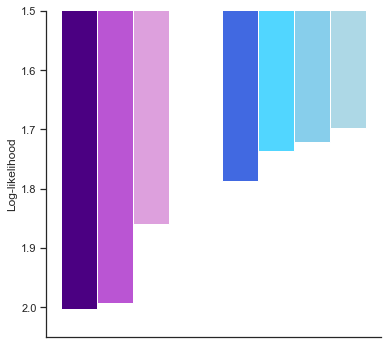

In [290]:
plt.figure(figsize=(6,6))
width = 0.2
b=6
c=4.5

(81/255, 214/255, 255/255)
plt.gca().invert_yaxis()
# plt.bar(width*1,np.mean(nhb_ru_c)/150,width=width,color='dimgray')
plt.bar(width*(1),(v_bic)/9000,width=width,color='indigo')
plt.bar(width*(2),(ve_bic)/9000,width=width,color='mediumorchid')
plt.bar(width*(3),(vep_bic)/9000,width=width,color='plum')

plt.bar(width*(c+1),(glm_v_bic)/9000,width=width,color='royalblue')
plt.bar(width*(c+2),(glm_e_bic)/9000,width=width,color=(81/255, 214/255, 255/255))
plt.bar(width*(c+3),(glm_p_bic)/9000,width=width,color='skyblue')
plt.bar(width*(c+4),(glm_vep_bic)/9000,width=width,color='lightblue')
# plt.bar(width*(c+5),np.mean(nhb_glm_ru_c_vep)/150,width=width,color='lightcyan',label='GLM:DUP')
# plt.yticks([-0.8,-0.85,-0.9,-0.95,-1])
plt.ylim(2.05,1.5)
plt.xticks([])
plt.ylabel('Log-likelihood')
sns.set(style='ticks')
sns.despine()
plt.show()

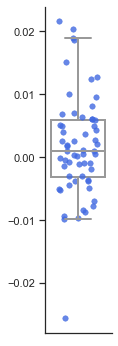

In [99]:
x = (np.random.random((60))-np.ones((60))*0.5)*0.6
plt.figure(figsize=(1.2,6))
sns.boxplot(data=df_glm_vep["beta_a"],linewidth=2,fliersize=0,color='white')
plt.scatter(x,df_glm_vep["beta_a"],s=30,color='royalblue',linewidths=0.5,alpha=0.8)
# plt.yticks([-3,-2,-1,0,1,2])
plt.xticks([])
# plt.ylim([-4,2])
sns.set(style='ticks')
sns.despine()

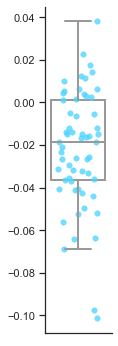

In [100]:
x = (np.random.random((60))-np.ones((60))*0.5)*0.6
plt.figure(figsize=(1.2,6))
sns.boxplot(data=df_glm_vep["phi_a"],linewidth=2,fliersize=0,color='white')
plt.scatter(x,df_glm_vep["phi_a"],s=30,color=(81/255, 214/255, 255/255),linewidths=0.5,alpha=0.8)
# plt.yticks([-3,-2,-1,0,1,2])
plt.xticks([])
# plt.ylim([-4,2])
sns.set(style='ticks')
sns.despine()

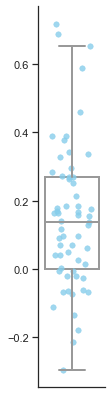

In [103]:
x = (np.random.random((60))-np.ones((60))*0.5)*0.6
plt.figure(figsize=(1.2,7))
sns.boxplot(data=df_glm_vep["persev_a"],linewidth=2,fliersize=0,color='white')
plt.scatter(x,df_glm_vep["persev_a"],s=30,color='skyblue',linewidths=0.5,alpha=0.8)
# plt.yticks([-3,-2,-1,0,1,2])
plt.xticks([])
# plt.ylim([-4,2])
sns.set(style='ticks')
sns.despine()

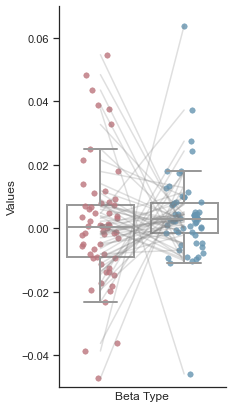

In [252]:
plt.figure(figsize=(3,7))
df_melted = pd.melt(df_glm2_vep, value_vars=['beta_a_1', 'beta_a_0'],var_name='Beta Type', value_name='Values')
# 绘制箱型图
for i in range(len(df_glm2_vep["beta_a_1"])):
    plt.plot([0,1],[df_glm2_vep["beta_a_1"][i],df_glm2_vep["beta_a_0"][i]],c='grey',alpha=0.25)
sns.boxplot(x='Beta Type', y='Values', data=df_melted,linewidth=2,fliersize=0,color='white')
x_1 = (np.random.random((60))-np.ones((60))*0.5)*0.45
plt.scatter(x_1,df_glm2_vep["beta_a_1"],s=30,color=(188/255,117/255,125/255),linewidths=0.5,alpha=0.8)
x_0 = (np.random.random((60))-np.ones((60))*0.5)*0.45+1
plt.scatter(x_0,df_glm2_vep["beta_a_0"],s=30,color=(102/255,149/255,177/255),linewidths=0.5,alpha=0.8)
plt.xticks([])
plt.ylim([-0.05,0.07])
sns.set(style='ticks')
sns.despine()

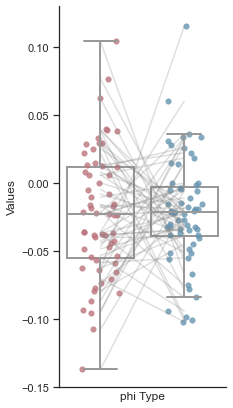

In [251]:
plt.figure(figsize=(3,7))
df_melted = pd.melt(df_glm2_vep, value_vars=['phi_a_1', 'phi_a_0'],var_name='phi Type', value_name='Values')
# 绘制箱型图
for i in range(len(df_glm2_vep["phi_a_1"])):
    plt.plot([0,1],[df_glm2_vep["phi_a_1"][i],df_glm2_vep["phi_a_0"][i]],c='grey',alpha=0.25)
sns.boxplot(x='phi Type', y='Values', data=df_melted,linewidth=2,fliersize=0,color='white')
x_1 = (np.random.random((60))-np.ones((60))*0.5)*0.45
plt.scatter(x_1,df_glm2_vep["phi_a_1"],s=30,color=(188/255,117/255,125/255),linewidths=0.5,alpha=0.8)
x_0 = (np.random.random((60))-np.ones((60))*0.5)*0.45+1
plt.scatter(x_0,df_glm2_vep["phi_a_0"],s=30,color=(102/255,149/255,177/255),linewidths=0.5,alpha=0.8)
plt.xticks([])
plt.ylim([-0.15,0.13])
sns.set(style='ticks')
sns.despine()

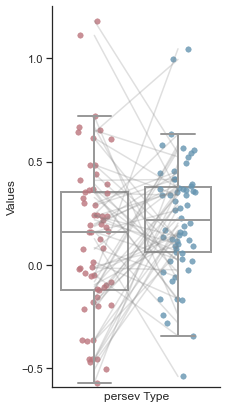

In [254]:
plt.figure(figsize=(3,7))
df_melted = pd.melt(df_glm2_vep, value_vars=['persev_a_1', 'persev_a_0'],var_name='persev Type', value_name='Values')
# 绘制箱型图
for i in range(len(df_glm2_vep["persev_a_1"])):
    plt.plot([0,1],[df_glm2_vep["persev_a_1"][i],df_glm2_vep["persev_a_0"][i]],c='grey',alpha=0.25)
sns.boxplot(x='persev Type', y='Values', data=df_melted,linewidth=2,fliersize=0,color='white')
x_1 = (np.random.random((60))-np.ones((60))*0.5)*0.45
plt.scatter(x_1,df_glm2_vep["persev_a_1"],s=30,color=(188/255,117/255,125/255),linewidths=0.5,alpha=0.8)
x_0 = (np.random.random((60))-np.ones((60))*0.5)*0.45+1
plt.scatter(x_0,df_glm2_vep["persev_a_0"],s=30,color=(102/255,149/255,177/255),linewidths=0.5,alpha=0.8)
plt.xticks([])
plt.yticks([-0.50,0.00,0.50,1.00])
plt.ylim([-0.59,1.251])
sns.set(style='ticks')
sns.despine()

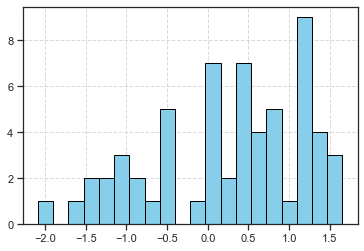

In [297]:
# 绘制直方图
plt.hist(df_glm_vep["persev_b"], bins=20, color='skyblue', edgecolor='black')  # bins控制分箱数
# plt.title("Histogram of Data Distribution")
# plt.xlabel("Value Range")
# plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线

# 显示图像
plt.show()